In [2]:
import os
import sys
sys.path = ["../utils"] + sys.path
from Bio import SeqIO
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.ticker as ticker
import scipy.stats as stats
import warnings
from aa_properties import *
from translate_dna import *
from count_aminoacid import *

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv(filepath_or_buffer='/home/kharlamov/Документы/Project_vas/output/ListProteins.csv')
data = data[data.columns[1:]]
data_tmp = data[data.columns[3:]]
data_tmp[data_tmp.columns[0]] = map(lambda x: 0 if x == 'human' else 1, data_tmp[data_tmp.columns[0]])
name_aminoacid = data_tmp.columns[1:]
data_tmp.head()

,type,A,N,C,E,H,L,M,P,T,...,R,D,Q,G,I,K,F,S,W,V
0,1,0.055072,0.017391,0.075362,0.046377,0.031884,0.095652,0.028986,0.052174,0.060870,...,0.057971,0.060870,0.031884,0.084058,0.040580,0.037681,0.034783,0.063768,0.017391,0.069565
1,1,0.092025,0.055215,0.018405,0.055215,0.024540,0.128834,0.012270,0.055215,0.036810,...,0.085890,0.036810,0.018405,0.116564,0.018405,0.006135,0.036810,0.061350,0.024540,0.085890
2,1,0.046875,0.015625,0.000000,0.046875,0.015625,0.093750,0.015625,0.046875,0.015625,...,0.250000,0.015625,0.046875,0.000000,0.015625,0.078125,0.093750,0.015625,0.000000,0.156250
3,1,0.058559,0.072072,0.018018,0.031532,0.022523,0.117117,0.013514,0.040541,0.112613,...,0.036036,0.018018,0.022523,0.072072,0.067568,0.036036,0.040541,0.085586,0.027027,0.081081
4,1,0.043636,0.043636,0.018182,0.025455,0.069091,0.087273,0.010909,0.040000,0.196364,...,0.036364,0.029091,0.029091,0.043636,0.061818,0.050909,0.032727,0.040000,0.021818,0.069091


In [4]:
with open('classifier_RF.pickle', 'rb') as f:
    clf_rf = pickle.load(f)

In [5]:
os.chdir('/home/kharlamov/Документы/Project_HIV/data/haplotypes/regions/fasta')

In [6]:
# Create dataset
df = pd.DataFrame({aminoacid : [] for aminoacid in data_tmp.columns[1:]})
df['patient'], df['region'], df['day'], df['n_reads'] = [], [], [], []

In [7]:
for file_name in os.listdir(os.curdir):
    for j, record in enumerate(SeqIO.parse(file_name, "fasta")):
        tempory = record.description.split(' ')
        day = int(tempory[4][:-1])
        n_reads = int(tempory[-1])
        region = file_name.split('_')[2].split('.')[0]
        patient = file_name.split('_')[1]
        tmp_data = [0] * 20 + list((patient, region, day, n_reads))
        tmp = count_aminoacid(translate_dna(record.seq))
        for i, elem in enumerate(name_aminoacid):
            tmp_data[i] = float(tmp.setdefault(elem, 0))/sum(tmp.values())
        df.loc[len(df) + 1] = tmp_data

In [8]:
test = df.sort_values(by = ['patient', 'day'])
test = test[test['n_reads'] > 50]

In [24]:
for p in ['p1', 'p2', 'p4', 'p5', 'p6', 'p8', 'p9', 'p10', 'p11']:
    for r in ['vpu', 'psi', 'V3']:
        df_tmp = test[(test['patient'] == p) & (test['region'] == r)]
        unique_days = df_tmp['day'].unique()
        for days in unique_days:
            tmp = df_tmp[(test['day'] == days)]
            prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
            plt.scatter([days] * len(prob), prob)
        plt.savefig('../../../../results/prob_plots/' + 'prob_' + p + '_' + r + '200''.png')
        plt.close()

In [15]:
def draw_graphics(df, patient, region, name_file = 'untiled', bool_save = False):
    df = test[(test['patient'] == patient) & (test['region'] == region)]
    y = list(map(lambda x: x[0], clf_rf.predict_proba(example[example.columns[:20]])))
    hue = example['day']
    size = example['n_reads']
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Days after infection')
    ax.set_ylabel('Probability that human protein') 
    ax.set_xlim([0, max(max(x) + 100, 300)])
    ax.set_ylim([min(y) - 0.05, max(y) + 0.05])
    
    sns.scatterplot(x = df['day'], y = y)
    print(df['day'])
    if bool_save:
        fig.savefig('../../../../results/prob_plots/' + name_file + '.png')
        plt.close(fig)

In [28]:
Coverage = {'V3' : [], 'psi' : [], 'vpu' : []}
for r in test['region'].unique():
    for p in test['patient'].unique():
        tempory_list = list(filter(lambda x: x < 10000, test[(test['patient'] == p) & (test['region'] == r)]['n_reads']))
        Coverage[r].append(sum(tempory_list) / max(1, len(tempory_list)))

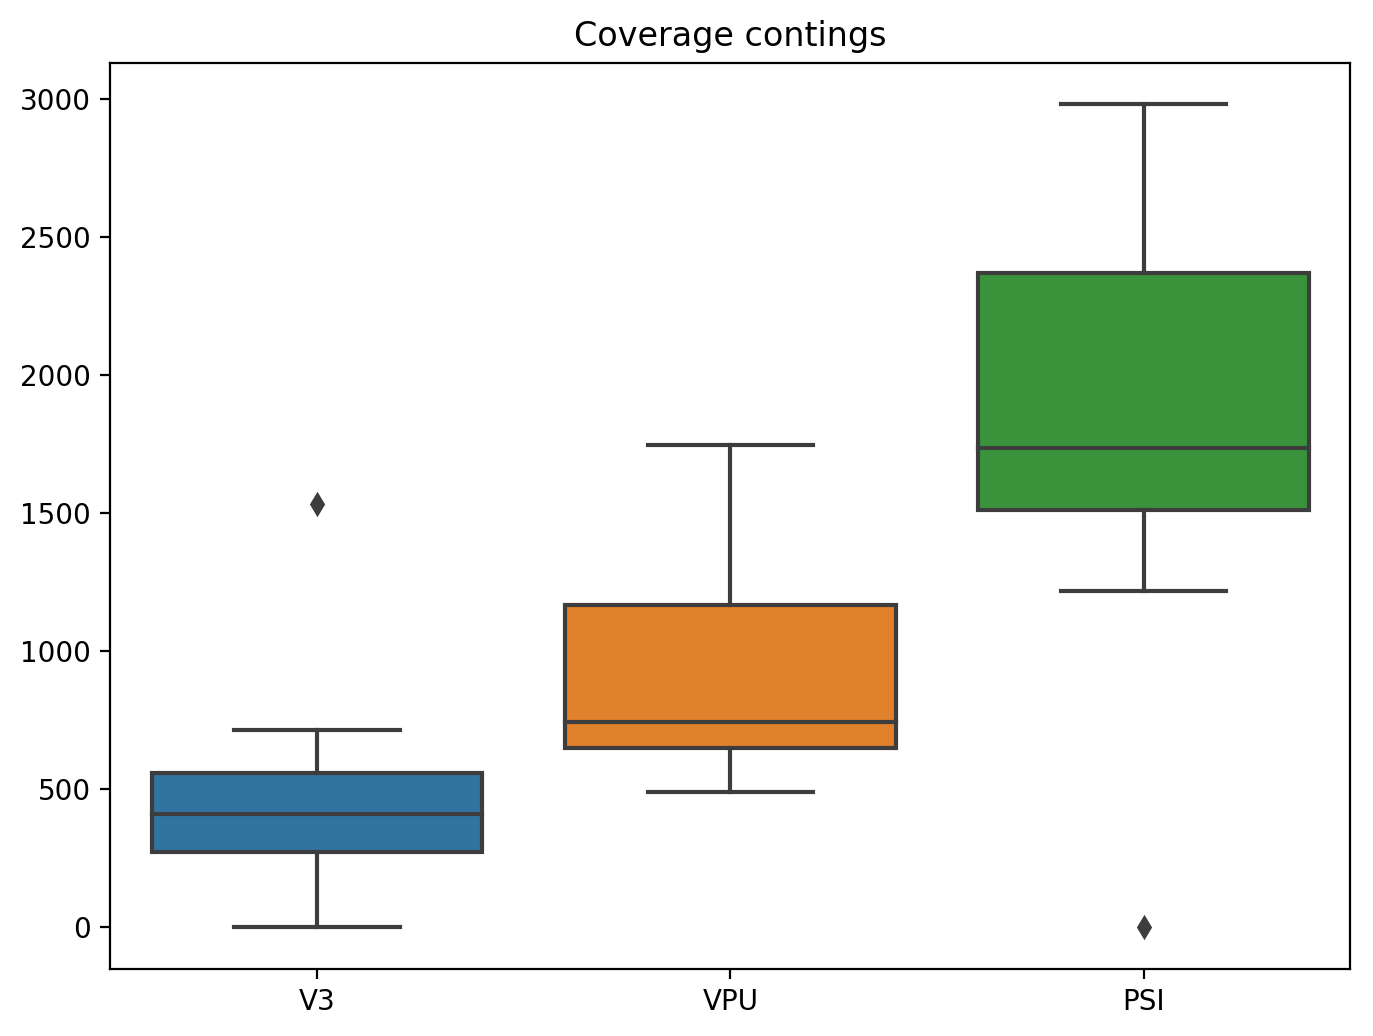

In [34]:
x = ['V3', 'VPU', 'PSI']
y = [Coverage['V3'], Coverage['vpu'], Coverage['psi']]
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
ax.set_title('Coverage contings')
sns.boxplot(x, y, ax = ax)

In [101]:
data = pd.read_csv('/home/kharlamov/Документы/Project_HIV/output/ListProteins.csv')

In [25]:
tes

1793

In [102]:
test.columns

Index([u'A', u'C', u'D', u'E', u'F', u'G', u'H', u'I', u'K', u'L', u'M', u'N',
       u'P', u'Q', u'R', u'S', u'T', u'V', u'W', u'Y', u'patient', u'region',
       u'day', u'n_reads'],
      dtype='object')

In [103]:
test_2 = pd.DataFrame(columns=data.columns[5:])

In [104]:
for col in data.columns[5:]:
    test_2[col] = test[col]
for col in test.columns[20:]:
    test_2[col] = test[col]

In [134]:
test = test_2
test = test.sort_values(by = ['patient', 'day'])
test = test[test['n_reads'] > 50]
for p in ['p1', 'p2', 'p4', 'p5', 'p6', 'p8', 'p9', 'p10', 'p11']:
    for r in ['vpu', 'psi', 'V3']:
        df_tmp = test[(test['patient'] == p) & (test['region'] == r)]
        unique_days = df_tmp['day'].unique()
        print(p, r,unique_days)
        for days in unique_days:
            tmp = df_tmp[(test['day'] == days)]
            prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
            plt.scatter([days] * len(prob), prob)
        plt.savefig('../../../../results/prob_plots/' + 'prob_' + p + '_' + r + '_50' + '.png')
        plt.close()

('p1', 'vpu', array([ 122.,  562., 1084., 1254., 1282., 1393., 2303., 2578., 2639.,
       2922.]))
('p1', 'psi', array([ 122.,  562., 1084., 1254., 1282., 1393., 1861., 2303., 2578.,
       2639., 2922., 2996.]))
('p1', 'V3', array([ 122., 1084., 1282., 1393., 1861., 2303., 2639., 2922., 2996.]))
('p2', 'vpu', array([  74.,  561.,  936., 1255., 1628., 2018.]))
('p2', 'psi', array([  74.,  561.,  936., 1255., 1628., 2018.]))
('p2', 'V3', array([  74.,  561.,  936., 2018.]))
('p4', 'vpu', array([  93.,  562., 1142., 1577., 1963., 2474., 2758., 3069.]))
('p4', 'psi', array([], dtype=float64))
('p4', 'V3', array([], dtype=float64))
('p5', 'vpu', array([ 134.,  303.,  713., 1057., 1414., 1813., 2149.]))
('p5', 'psi', array([ 303.,  713., 1057., 1414., 1813., 2149.]))
('p5', 'V3', array([ 134.,  713., 1057., 1414., 1813., 2149.]))
('p6', 'vpu', array([  62.,  118.,  974., 1293., 1724., 2178., 2556.]))
('p6', 'psi', array([  62.,  118.,  974., 1293., 1724., 2178., 2556.]))
('p6', 'V3', array

In [35]:
Coverage_haplo = {'V3' : [], 'vpu' : [], 'psi' : []}
patient = []
for file_name in os.listdir(os.curdir):
    for j, record in enumerate(SeqIO.parse(file_name, "fasta")):
        patient.append(file_name.split('_')[1])
        region = file_name.split('_')[2].split('.')[0]
        Coverage_haplo[region].append(int(len(record.seq)) - int(record.seq.count('-')))
        

In [209]:
x = ['V3', 'VPU', 'PSI']
y = [Coverage['V3'], Coverage['vpu'], Coverage['psi']]
sns.catplot(x, y)

TypeError: object of type 'NoneType' has no len()

In [36]:
A = pd.DataFrame()
A['lenght haplotype'] = Coverage_haplo['V3'] + Coverage_haplo['psi'] + Coverage_haplo['vpu']

In [37]:
A['region'] = ['V3'] * len(Coverage_haplo['V3']) + ['psi'] * len(Coverage_haplo['psi']) + ['vpu'] * len(Coverage_haplo['vpu'])

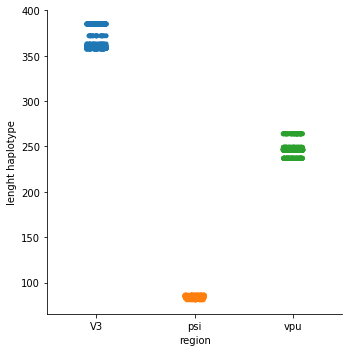

In [244]:
sns.catplot(y='lenght haplotype', x = 'region', data = A)

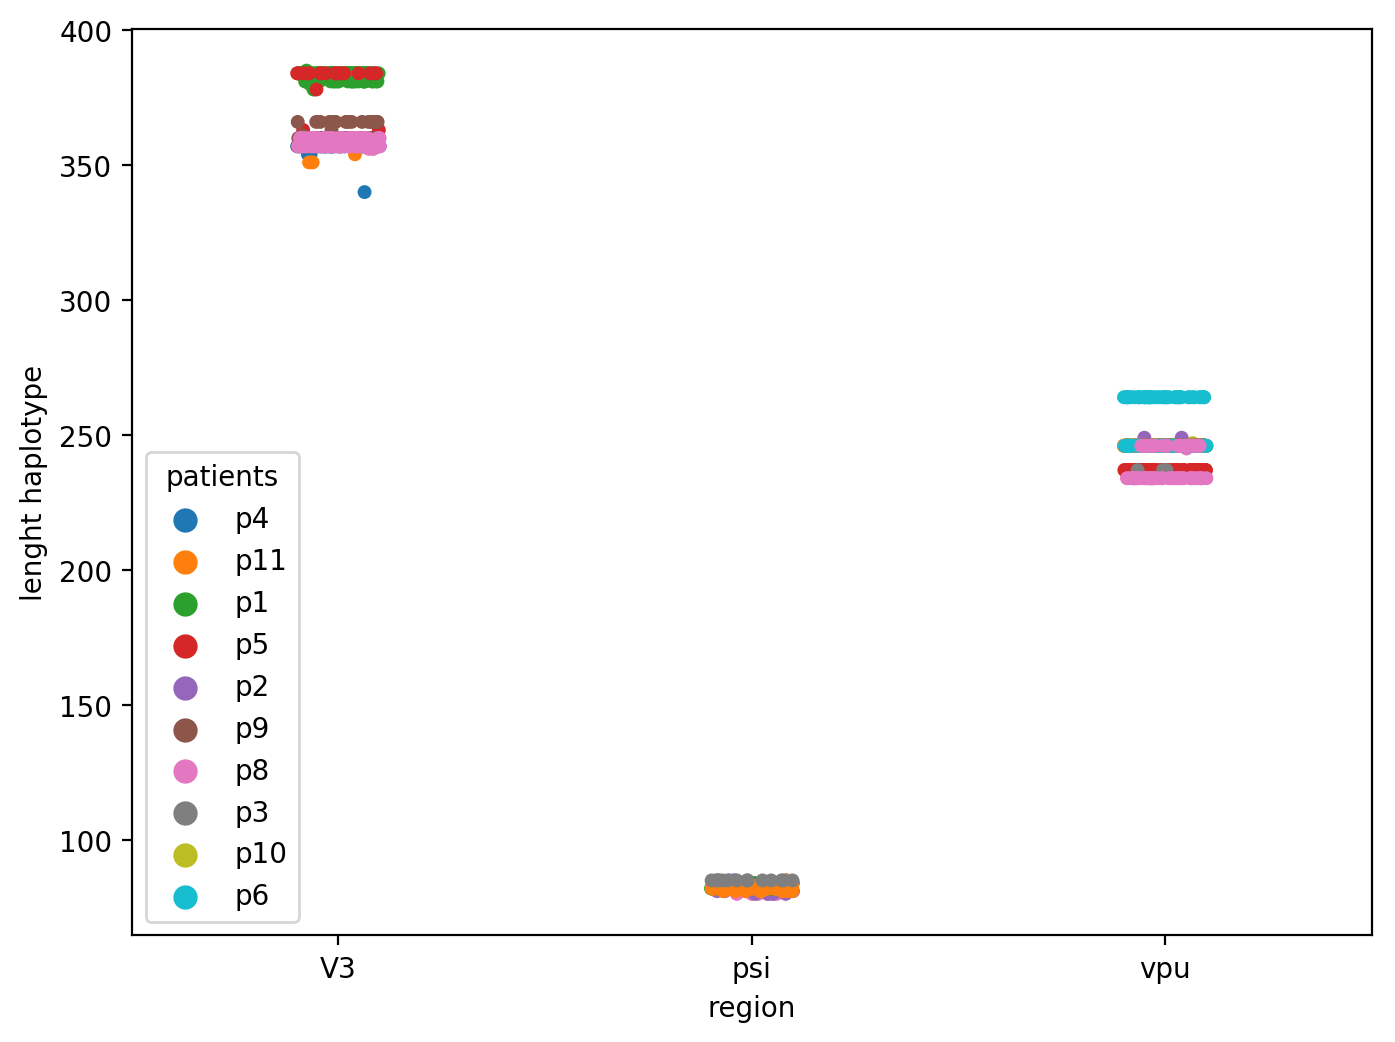

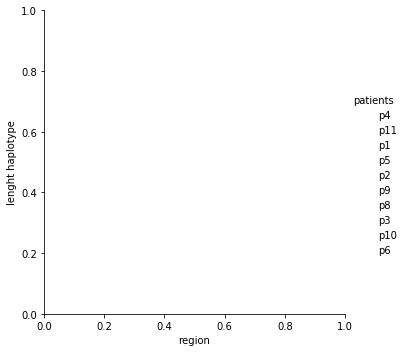

In [40]:
fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
sns.catplot(y='lenght haplotype', x = 'region', hue = 'patients', data = A, ax=ax)

In [38]:
A['patients'] = patient

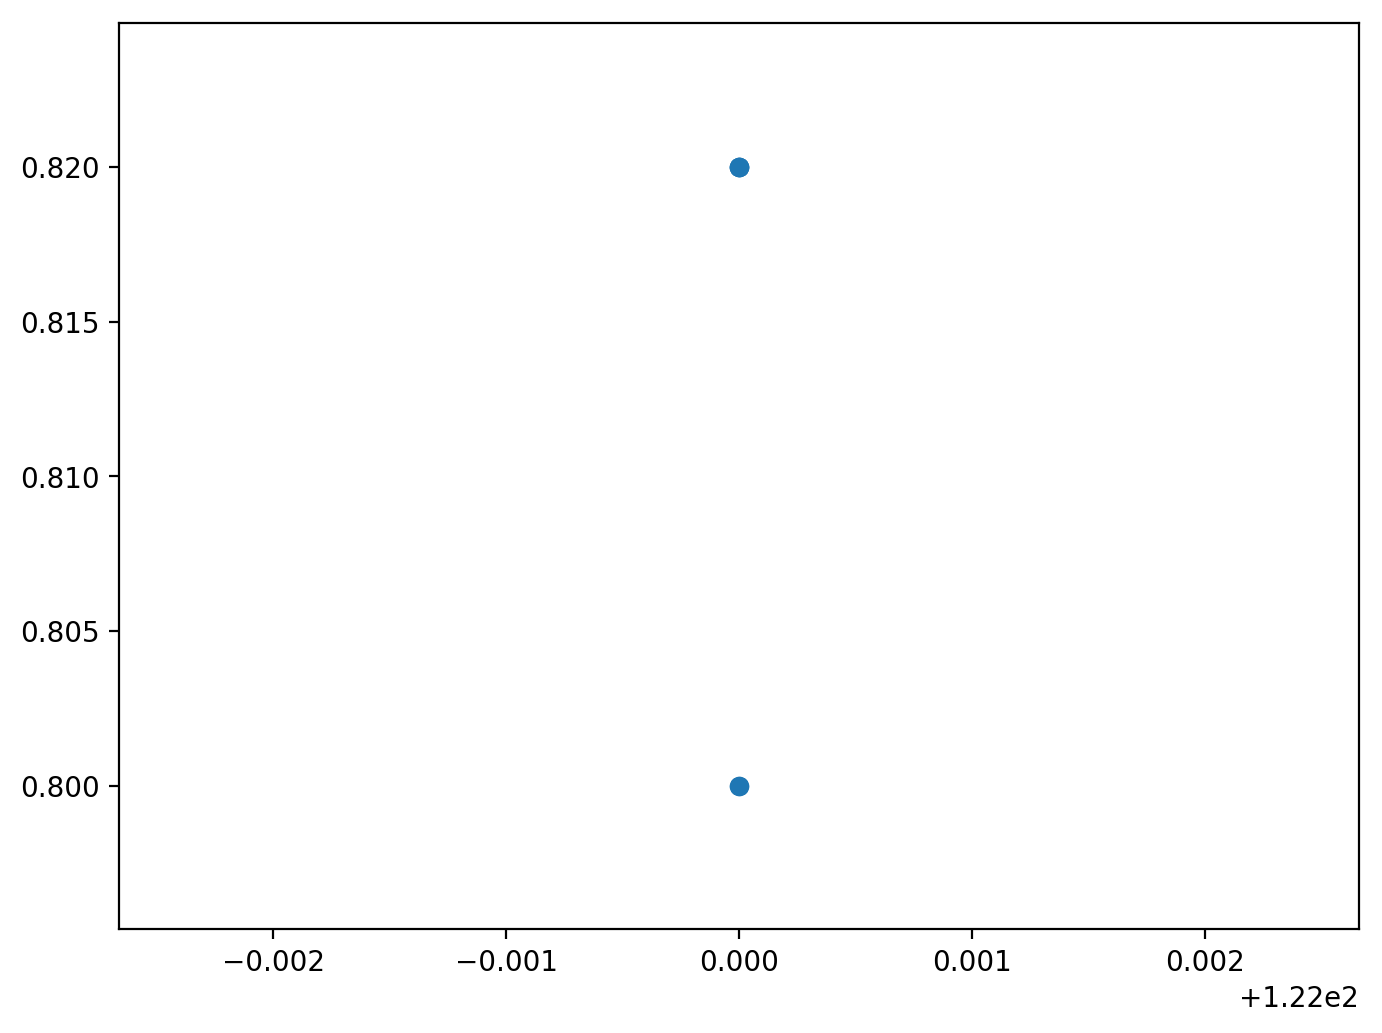

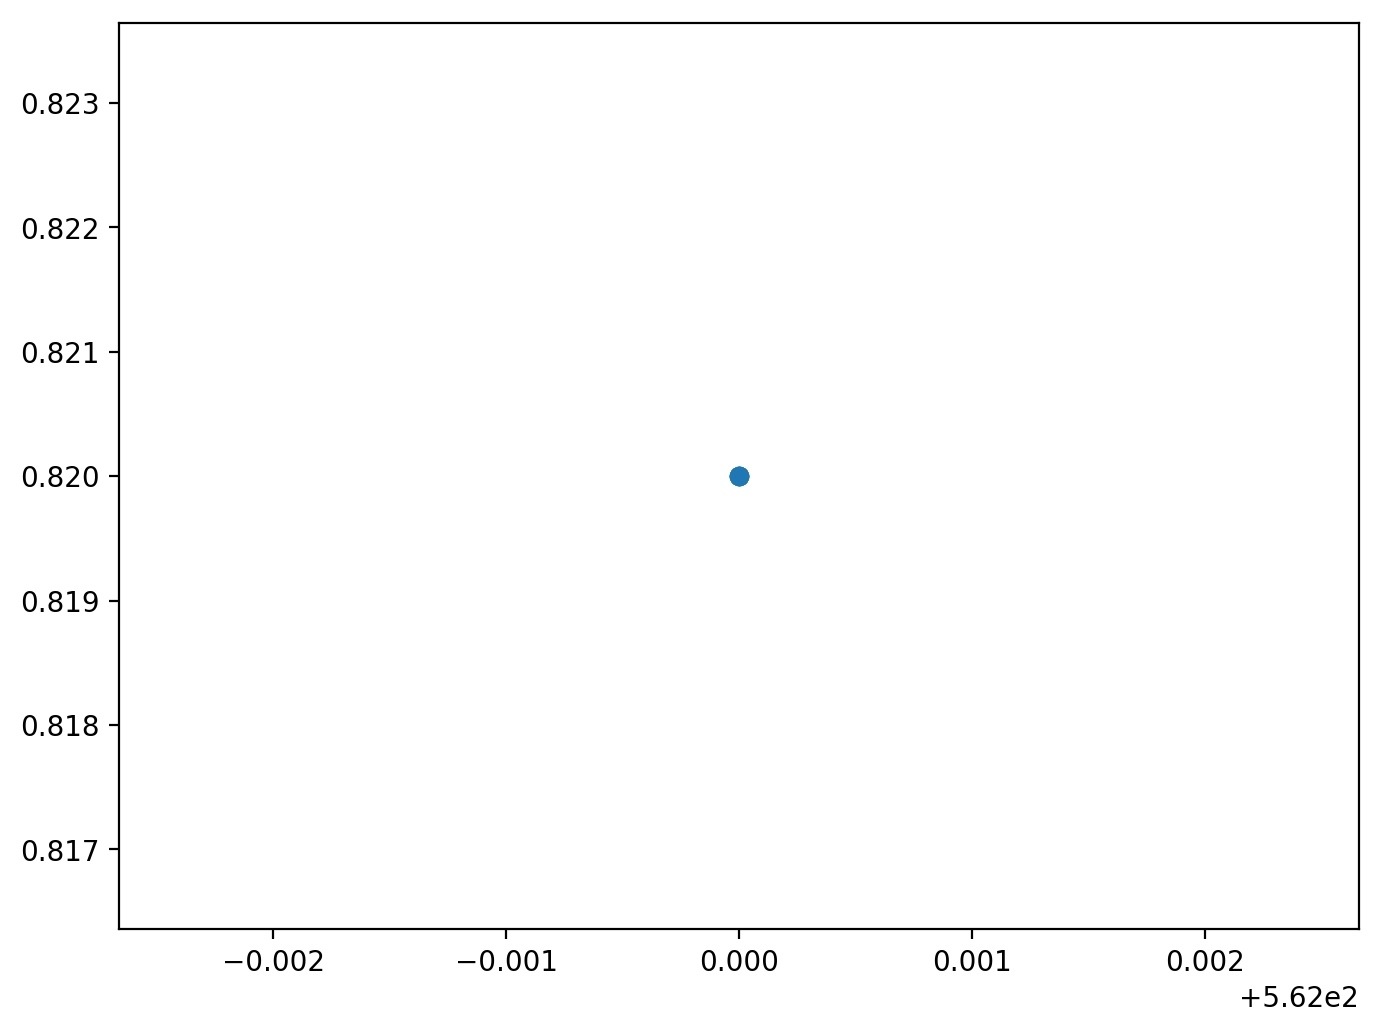

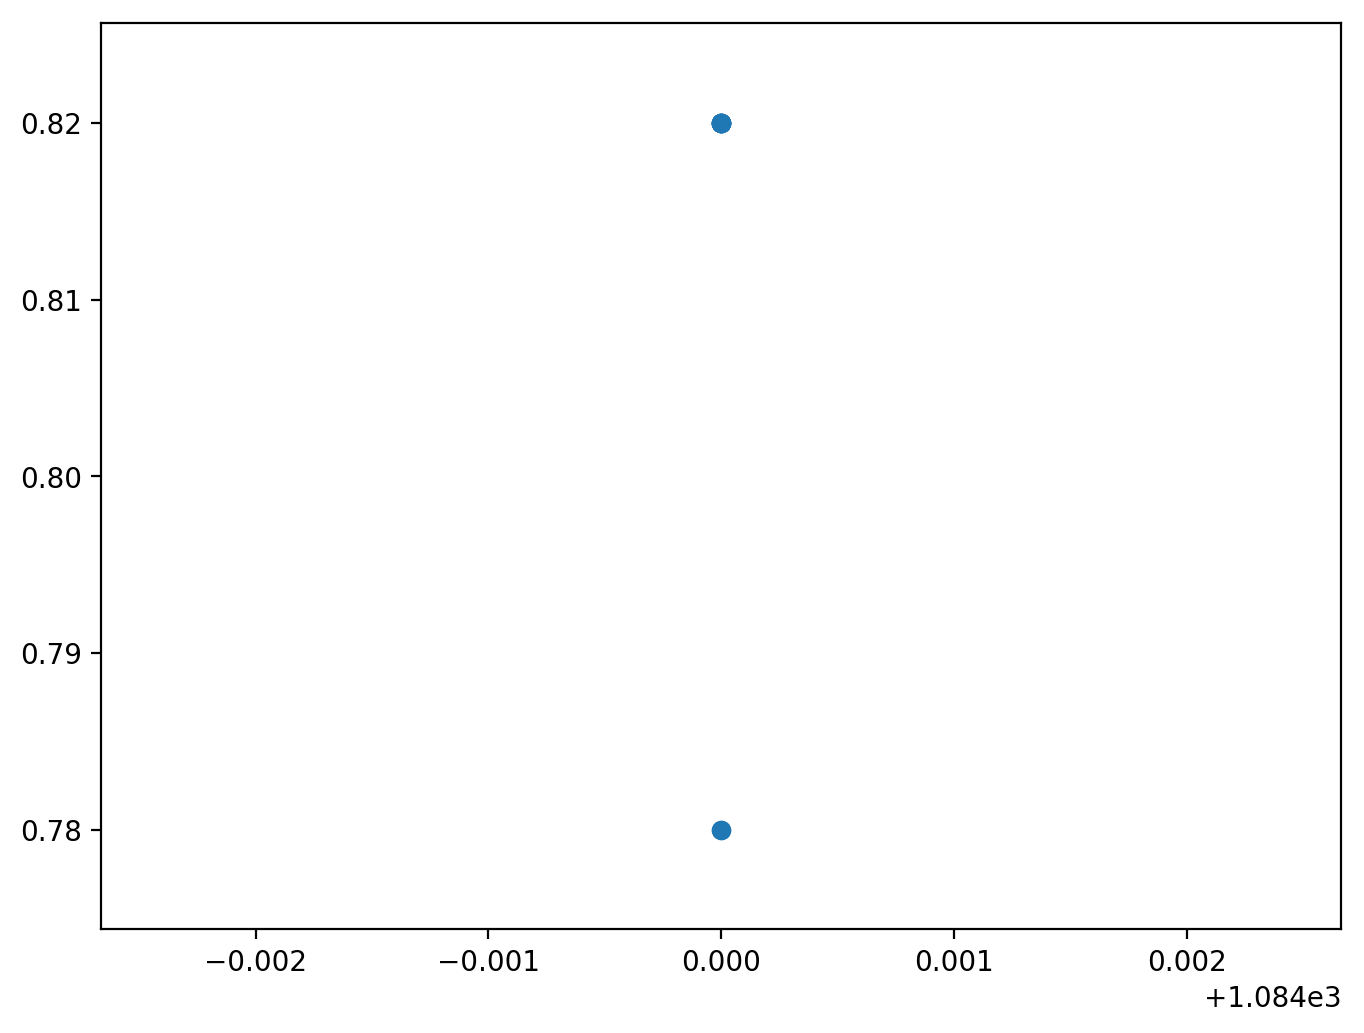

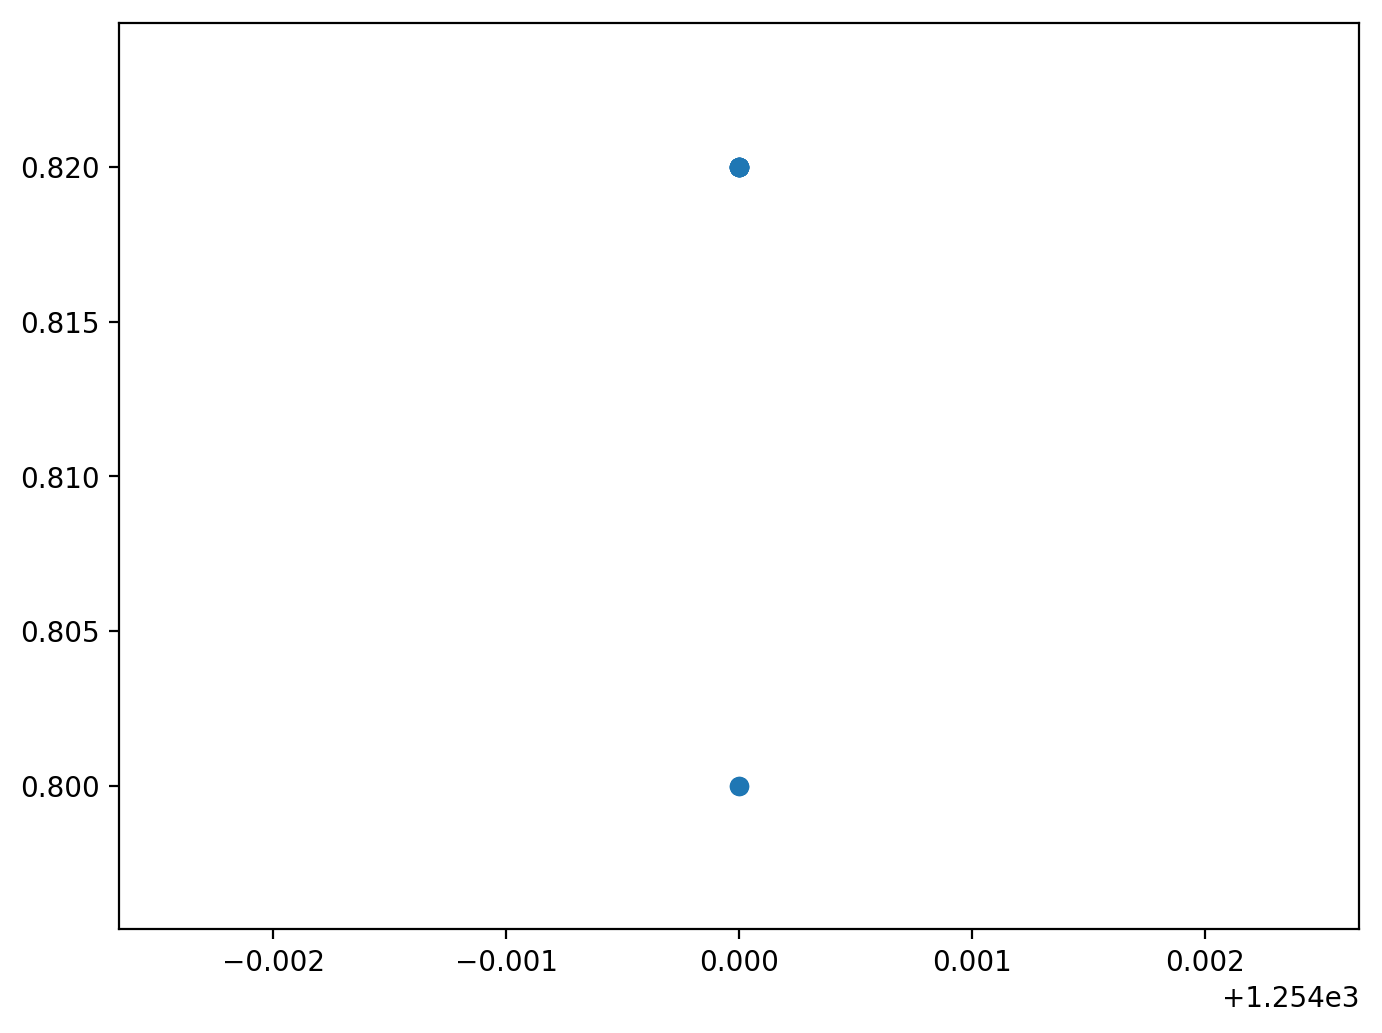

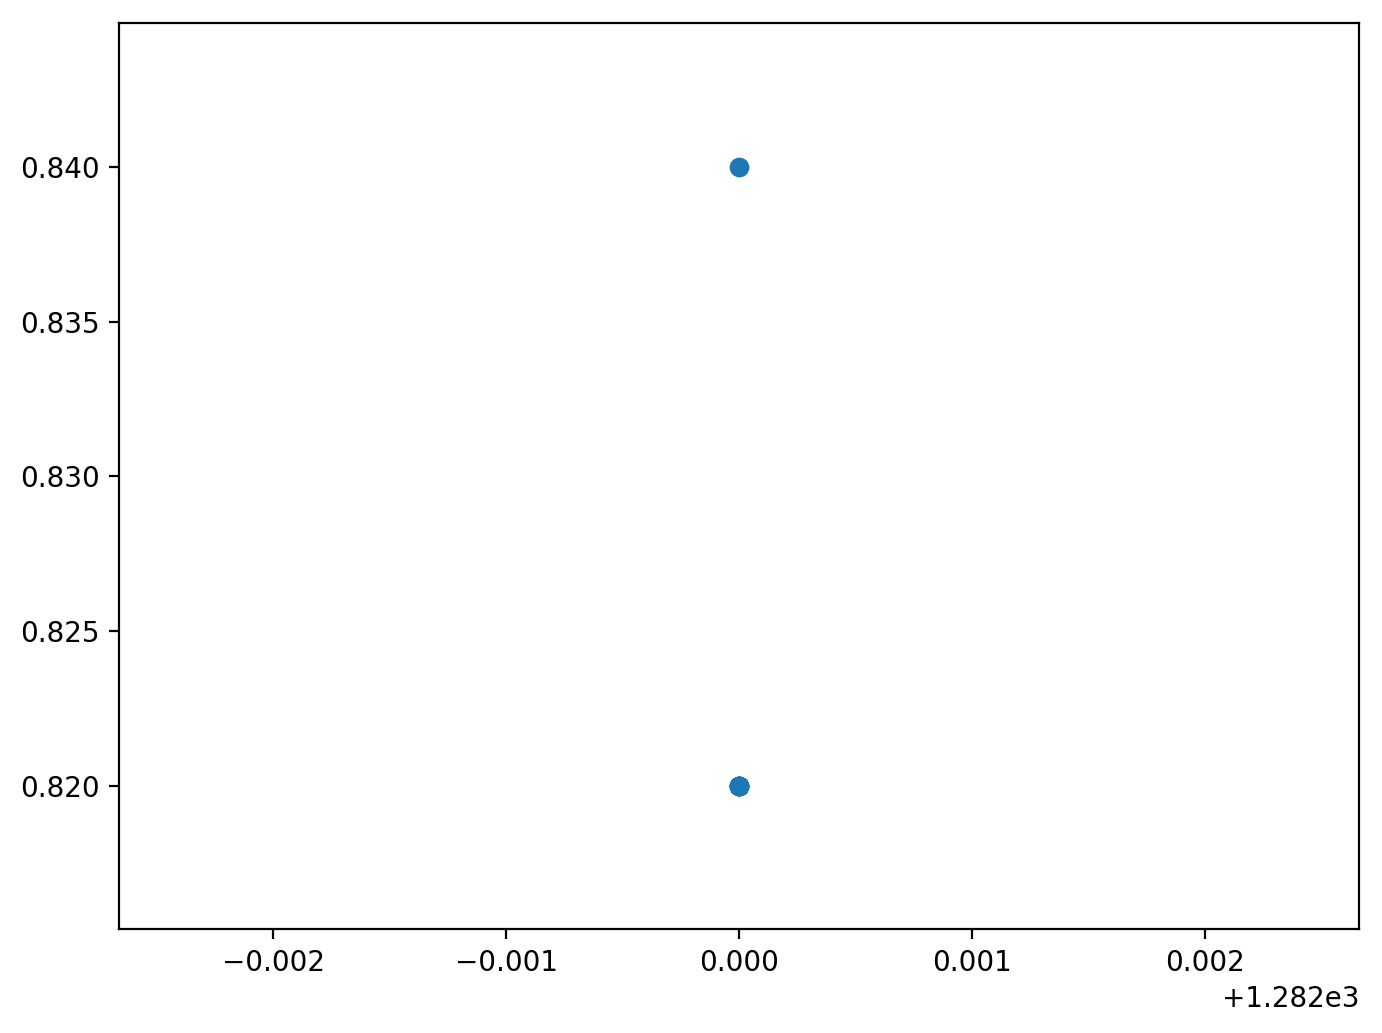

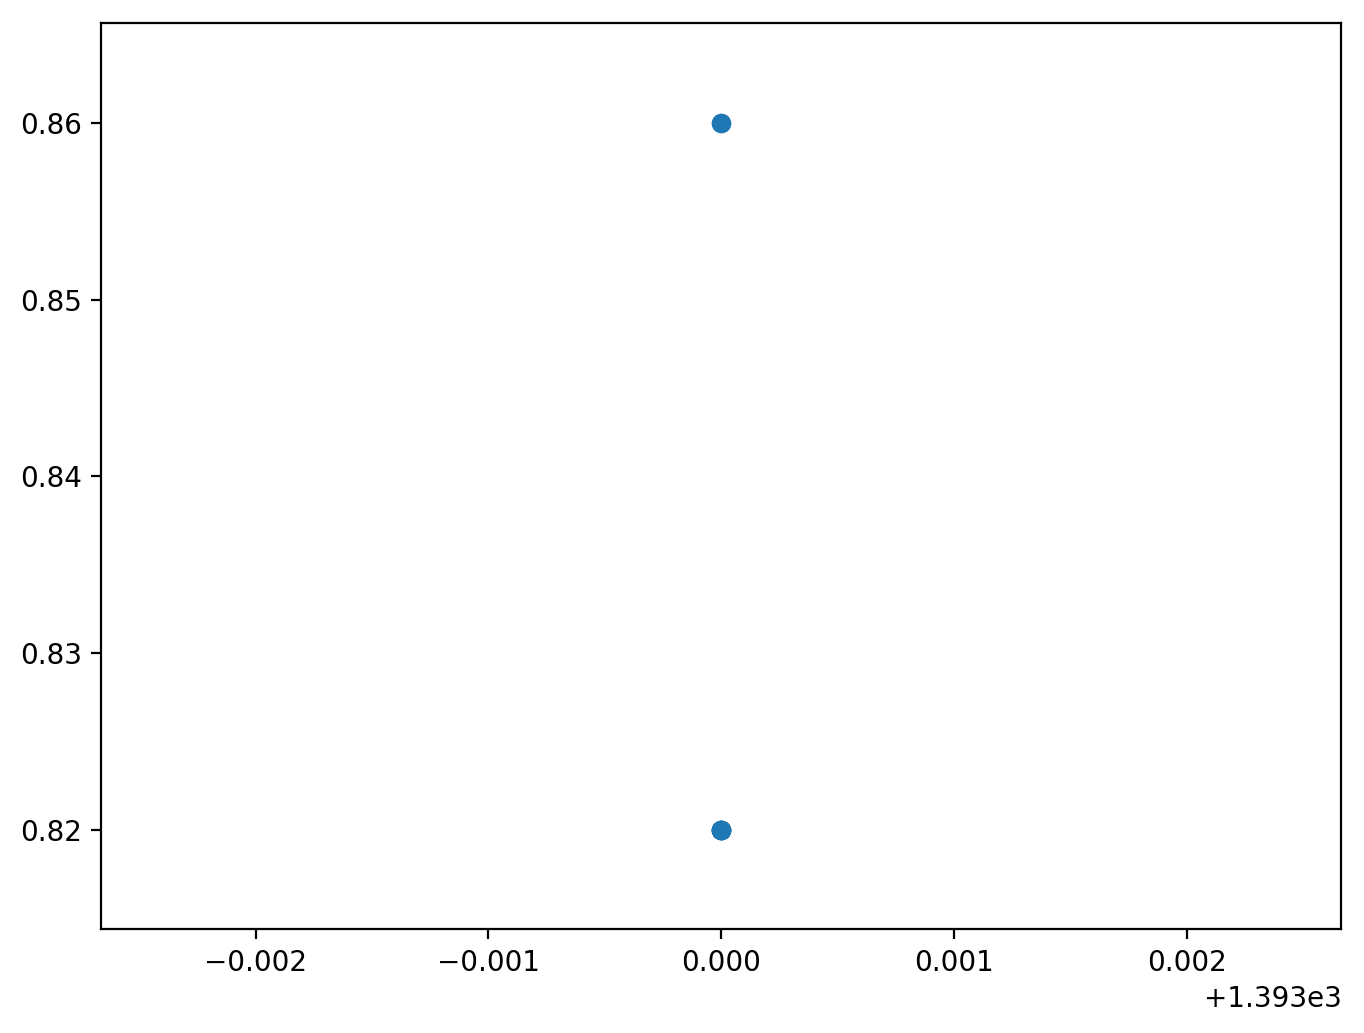

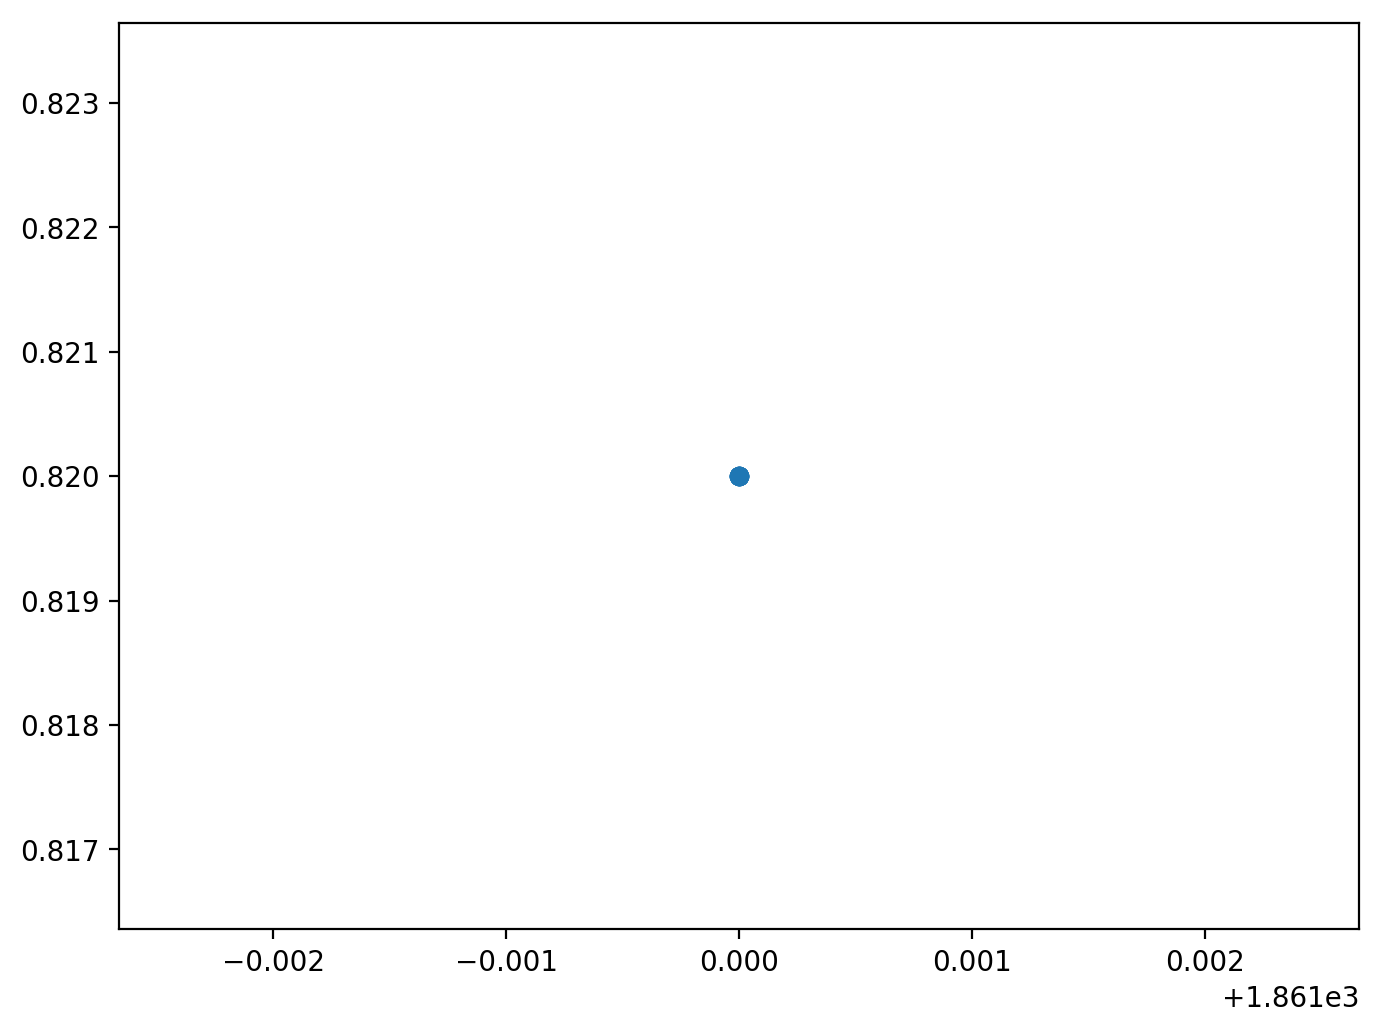

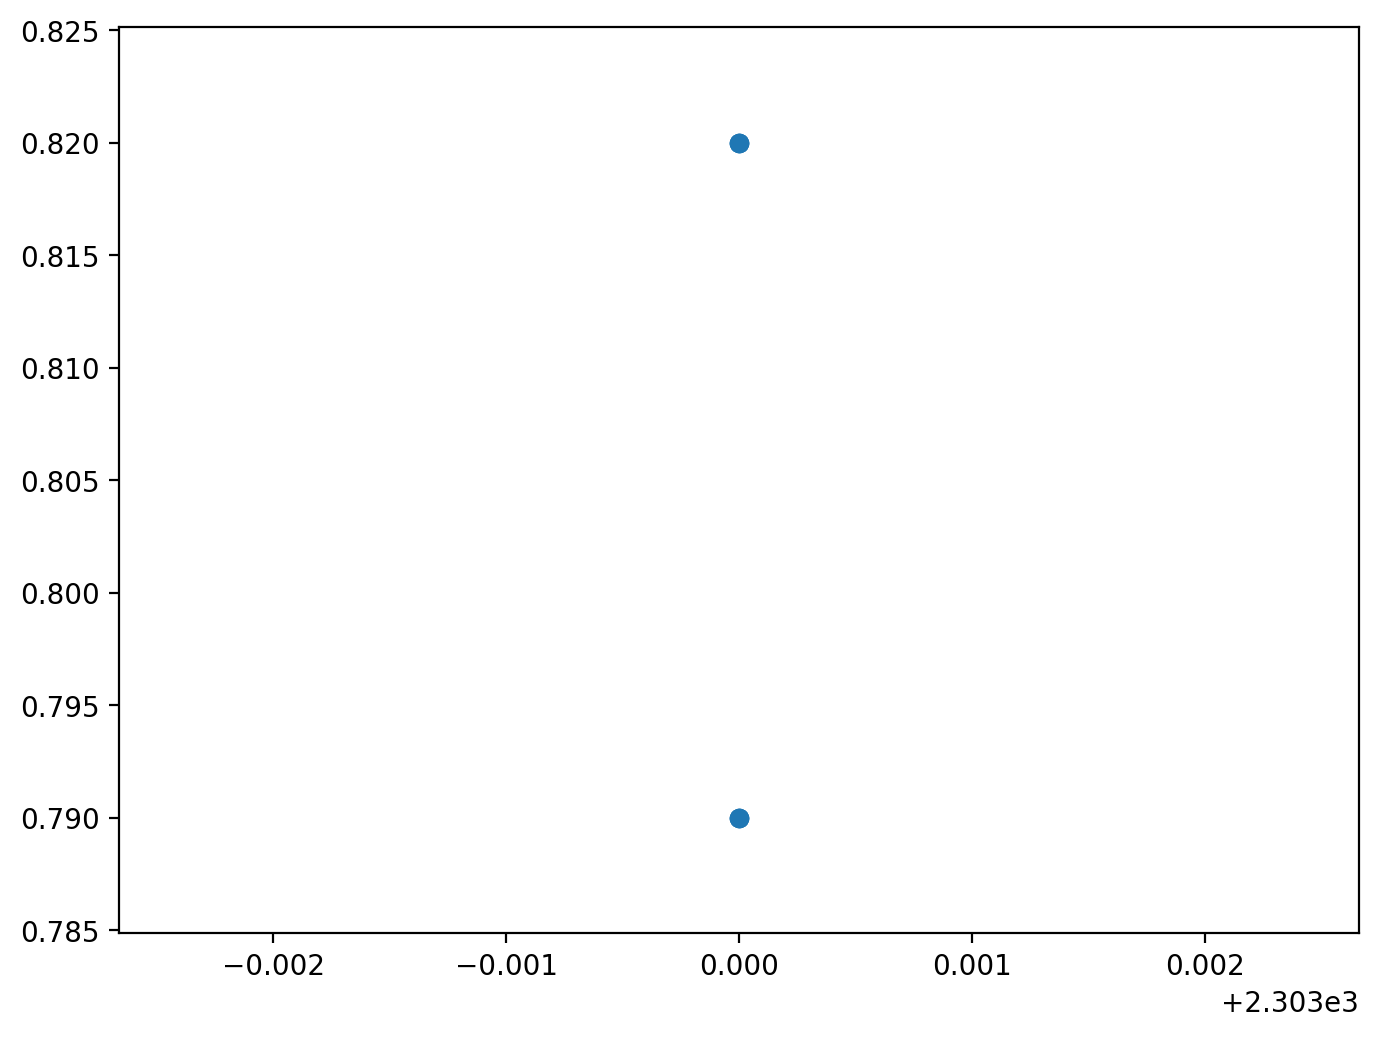

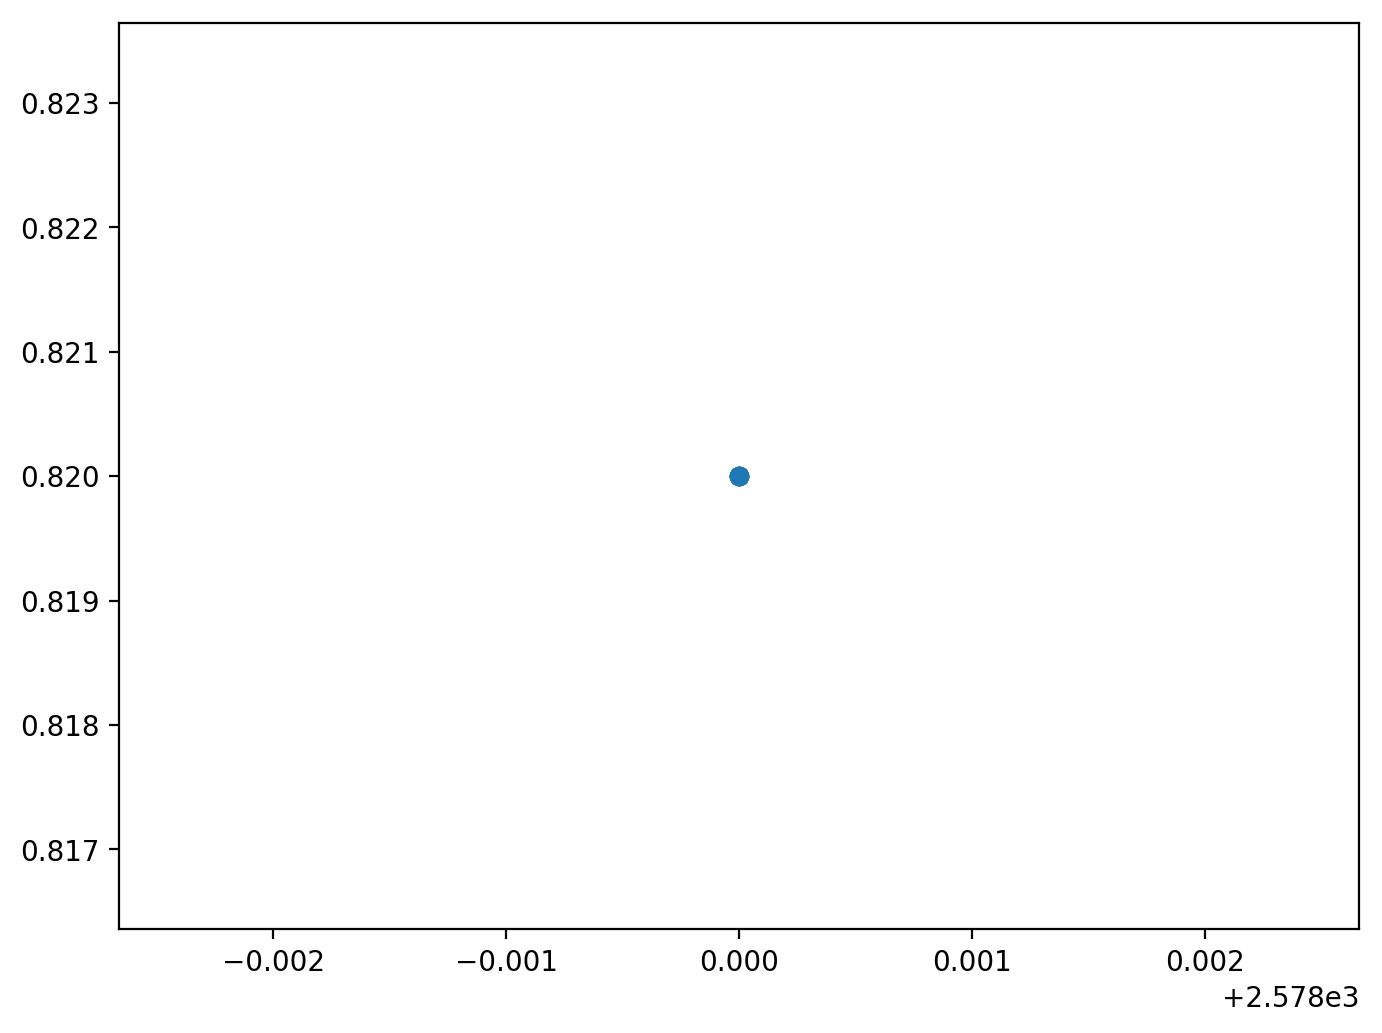

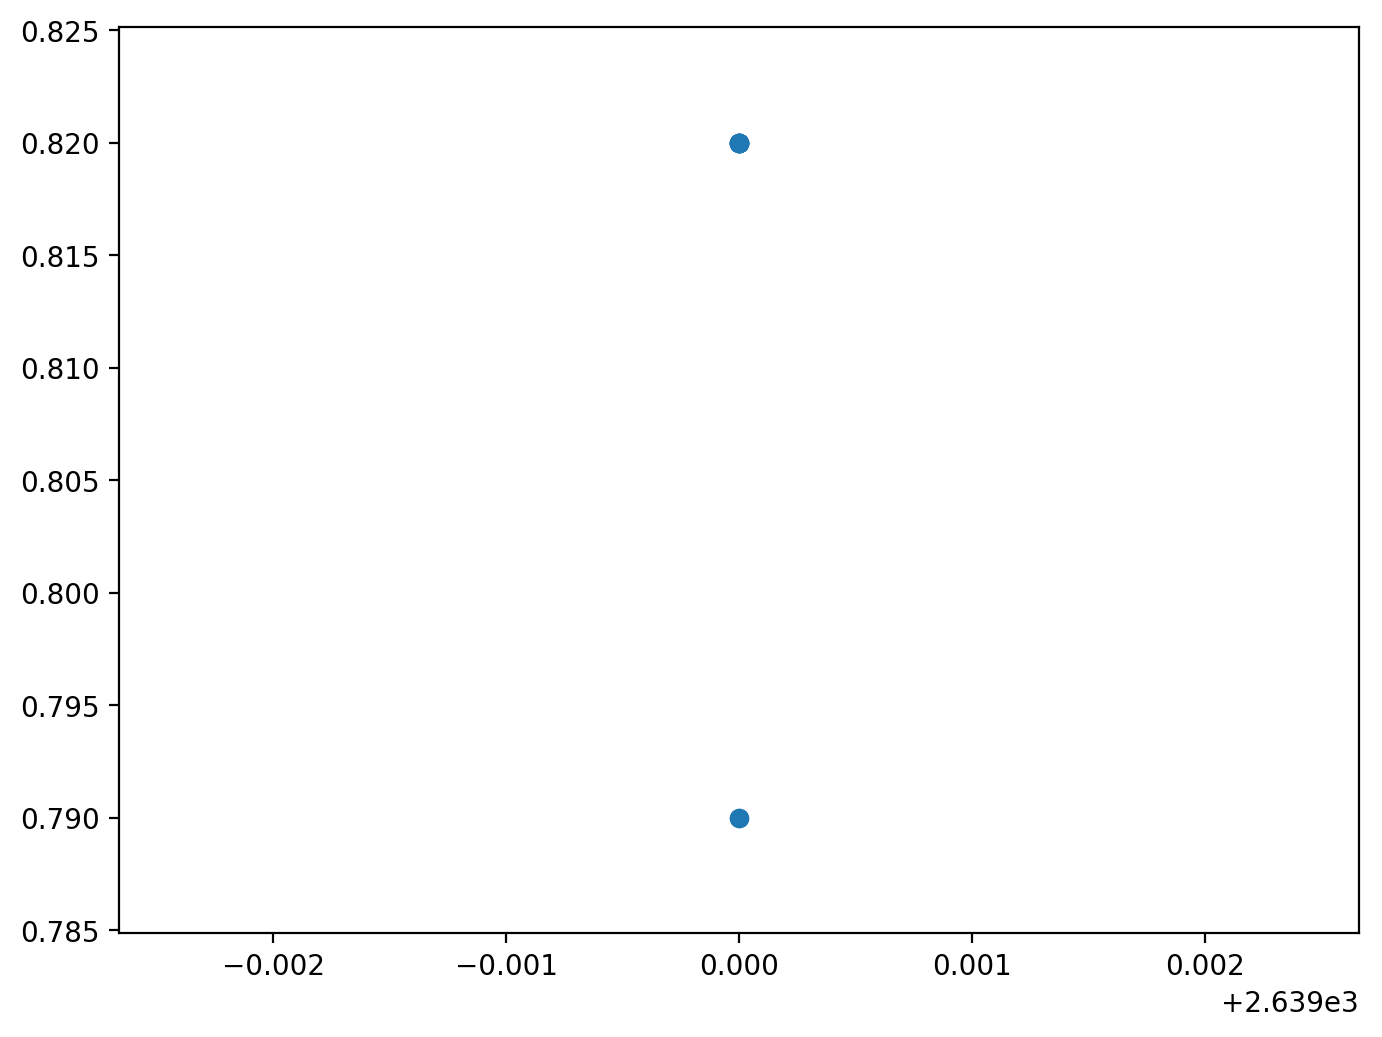

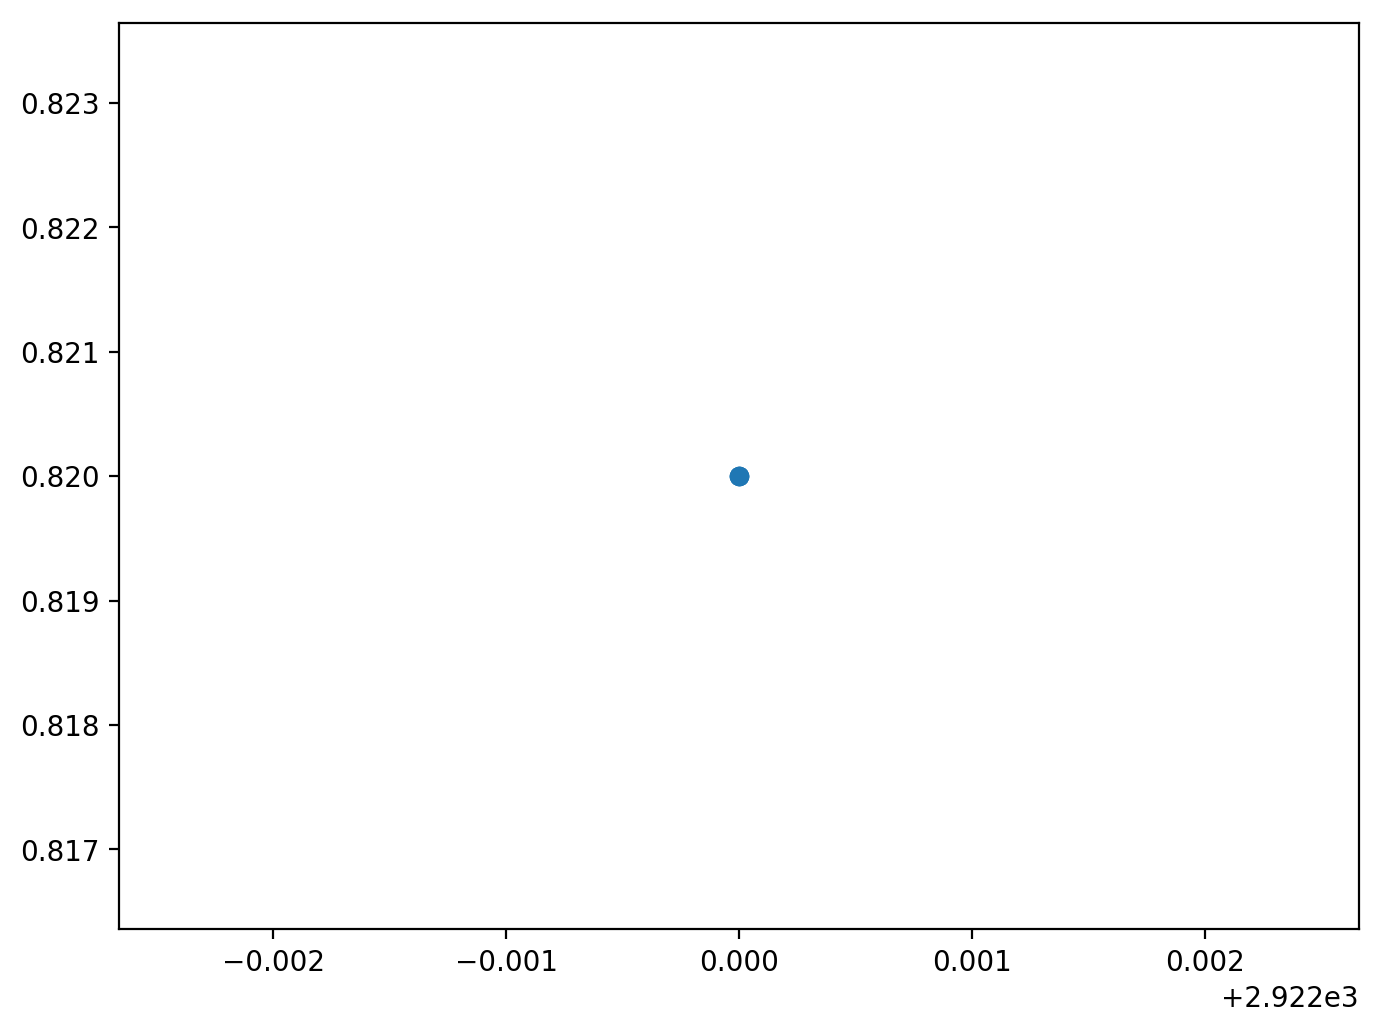

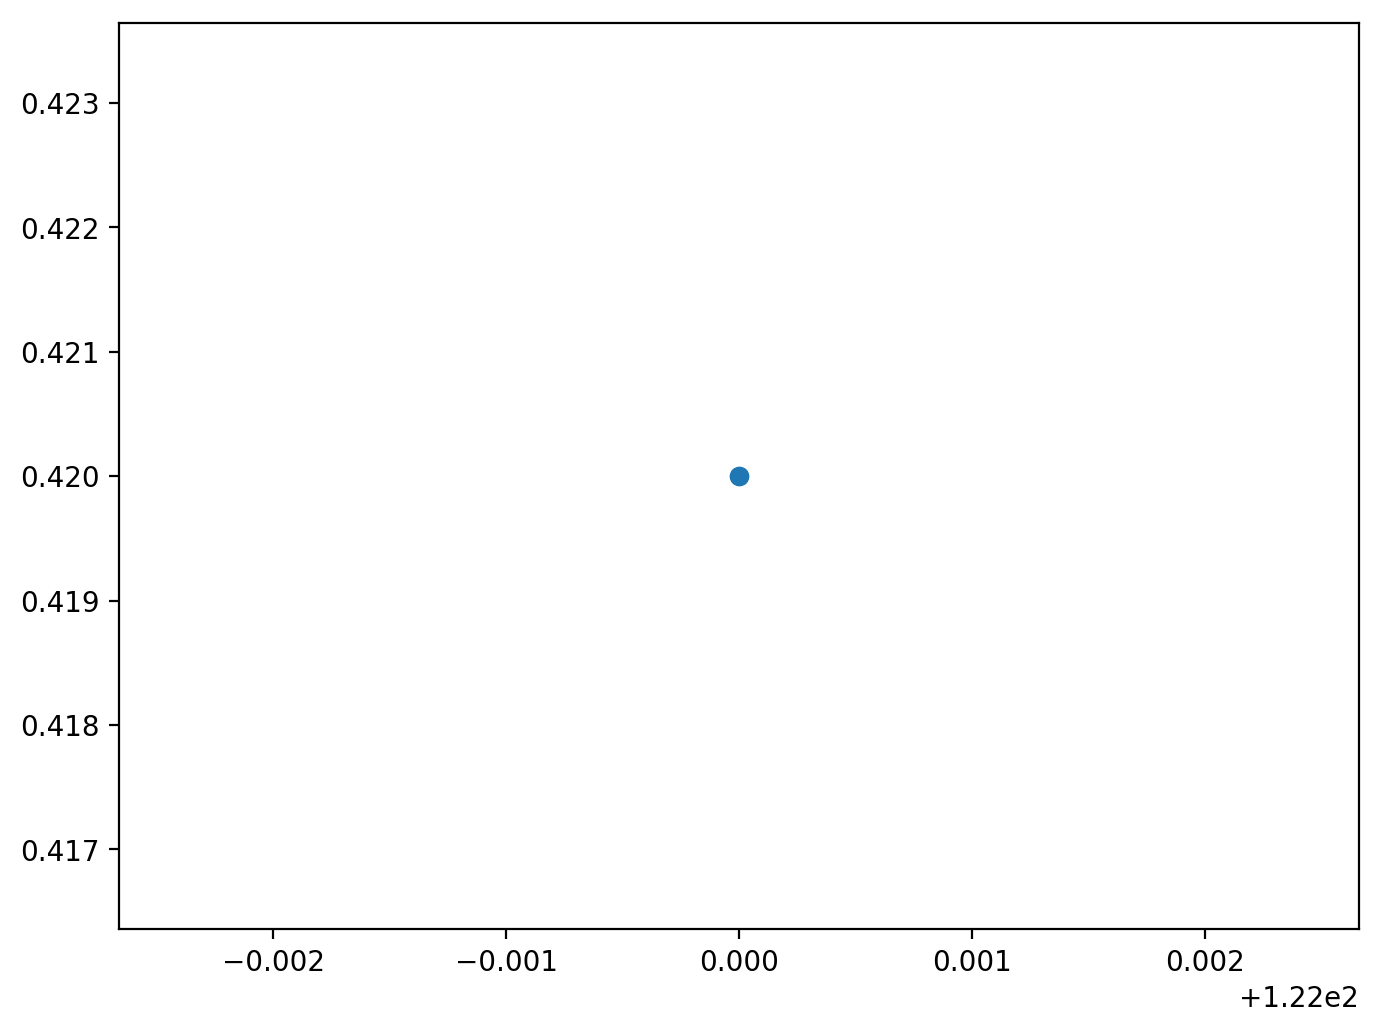

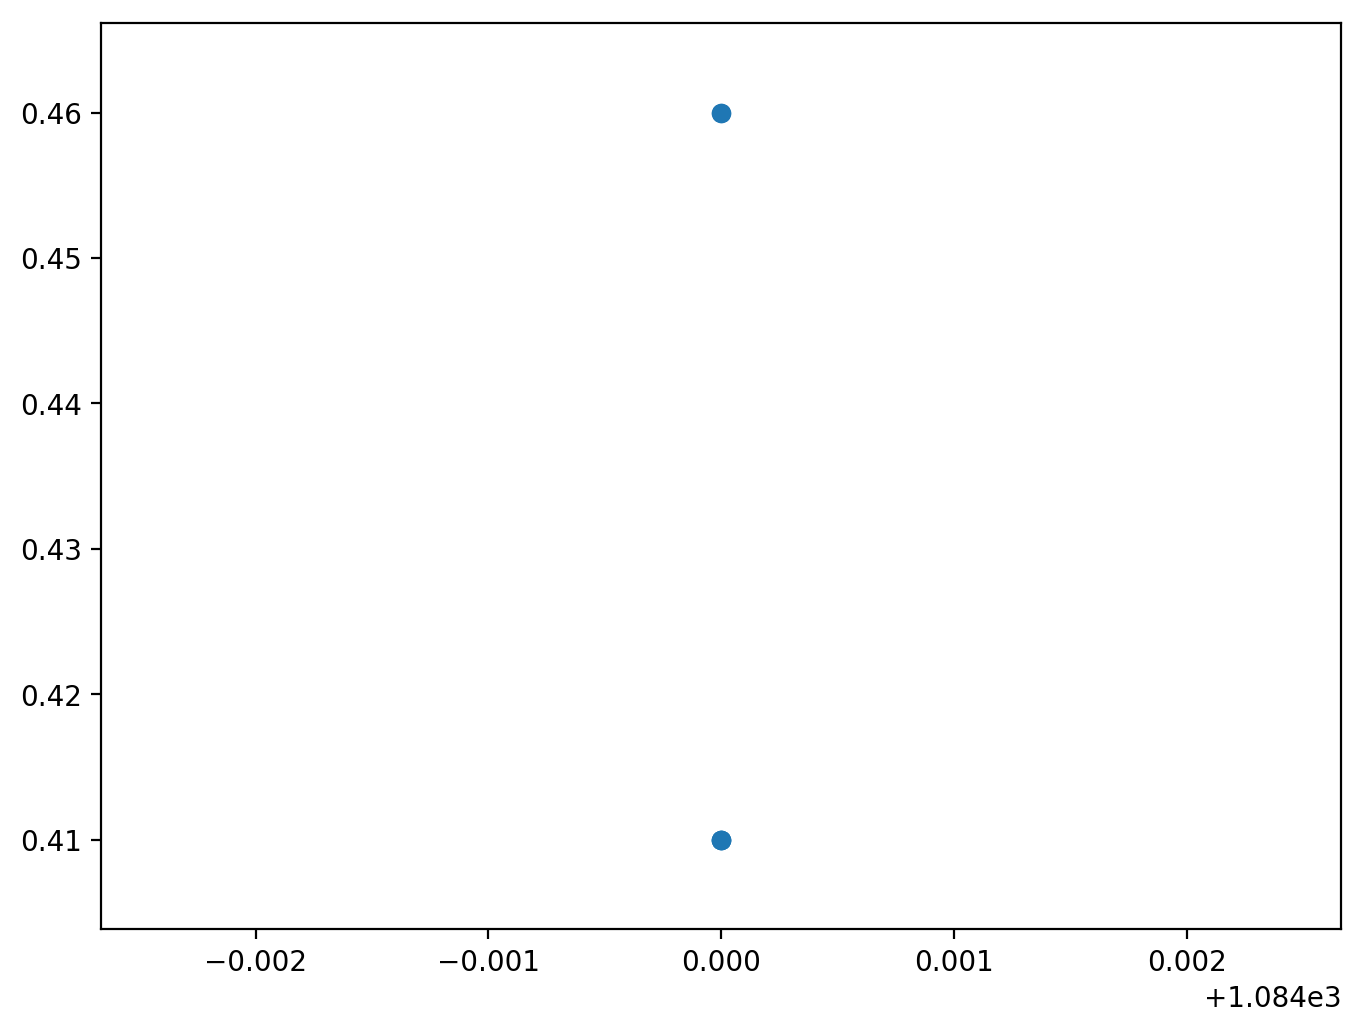

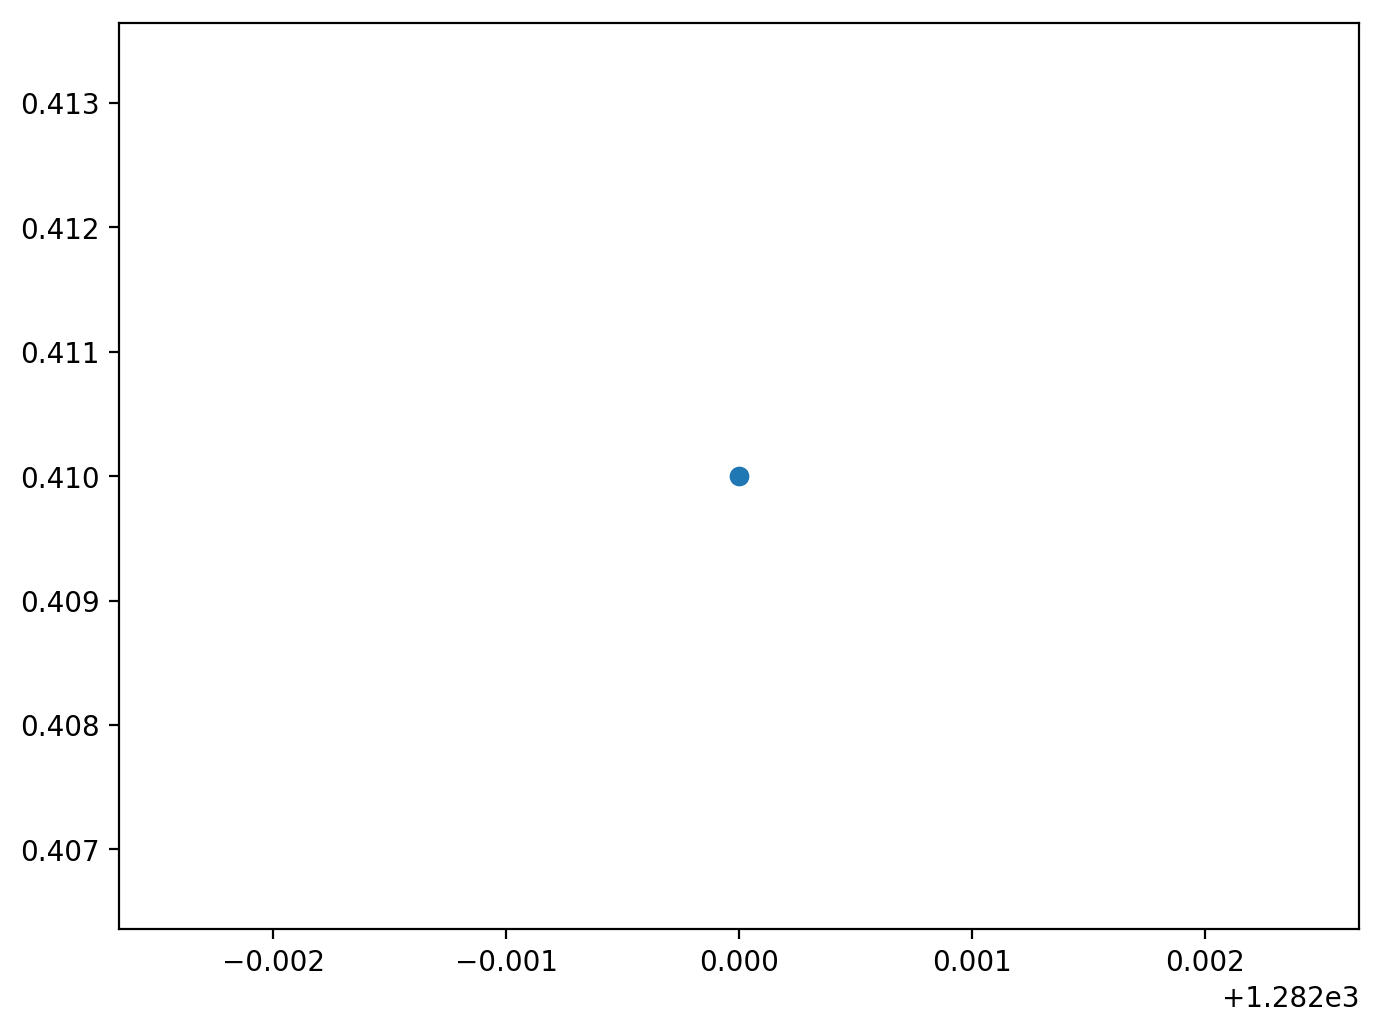

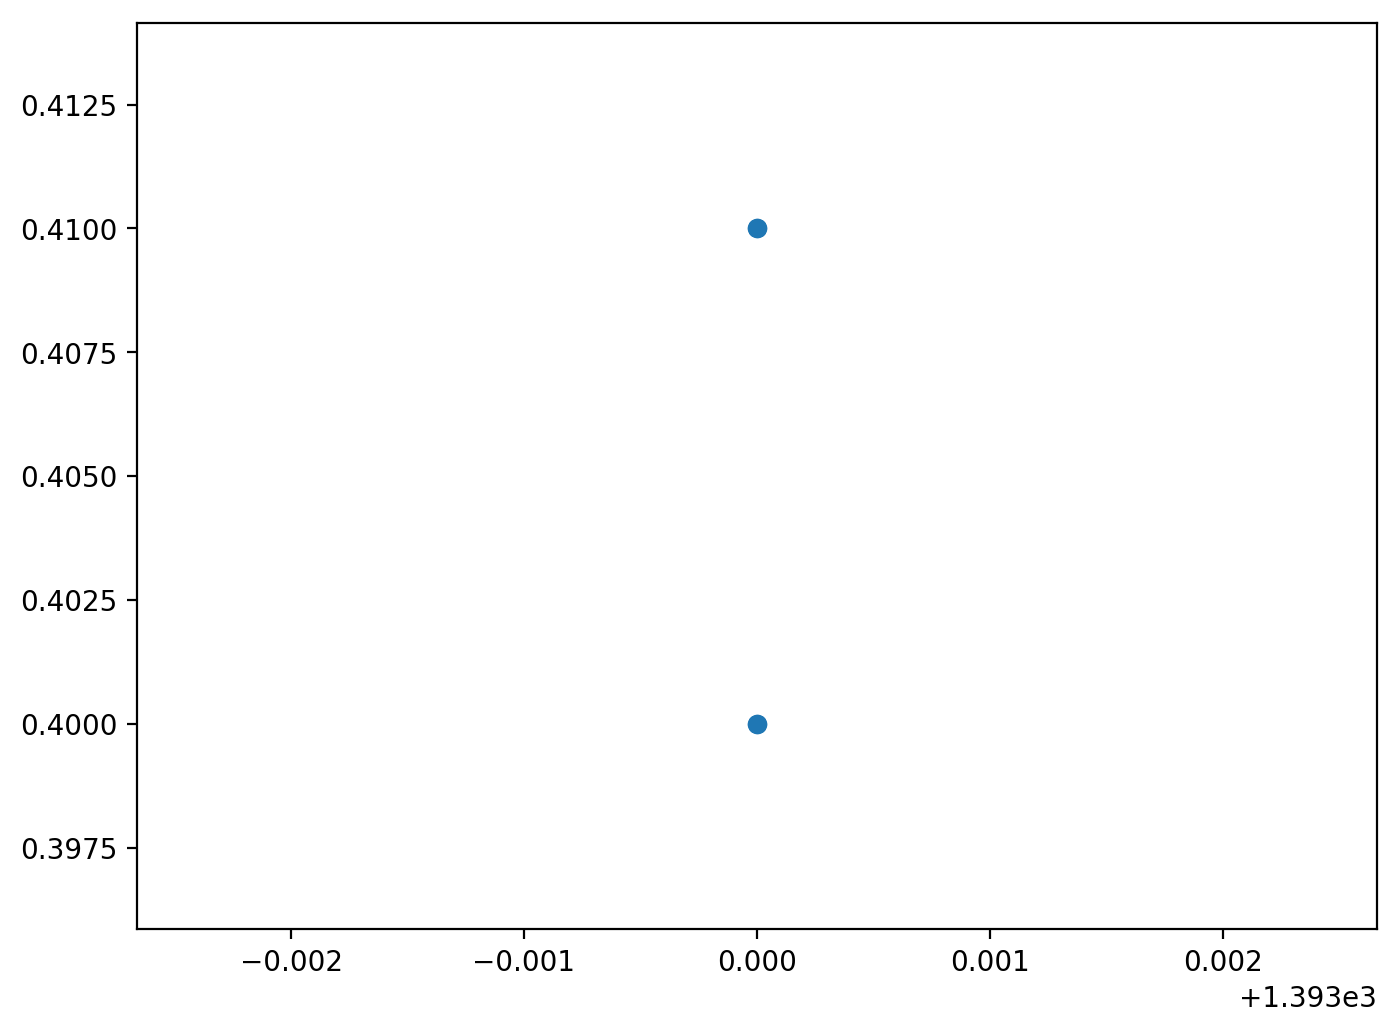

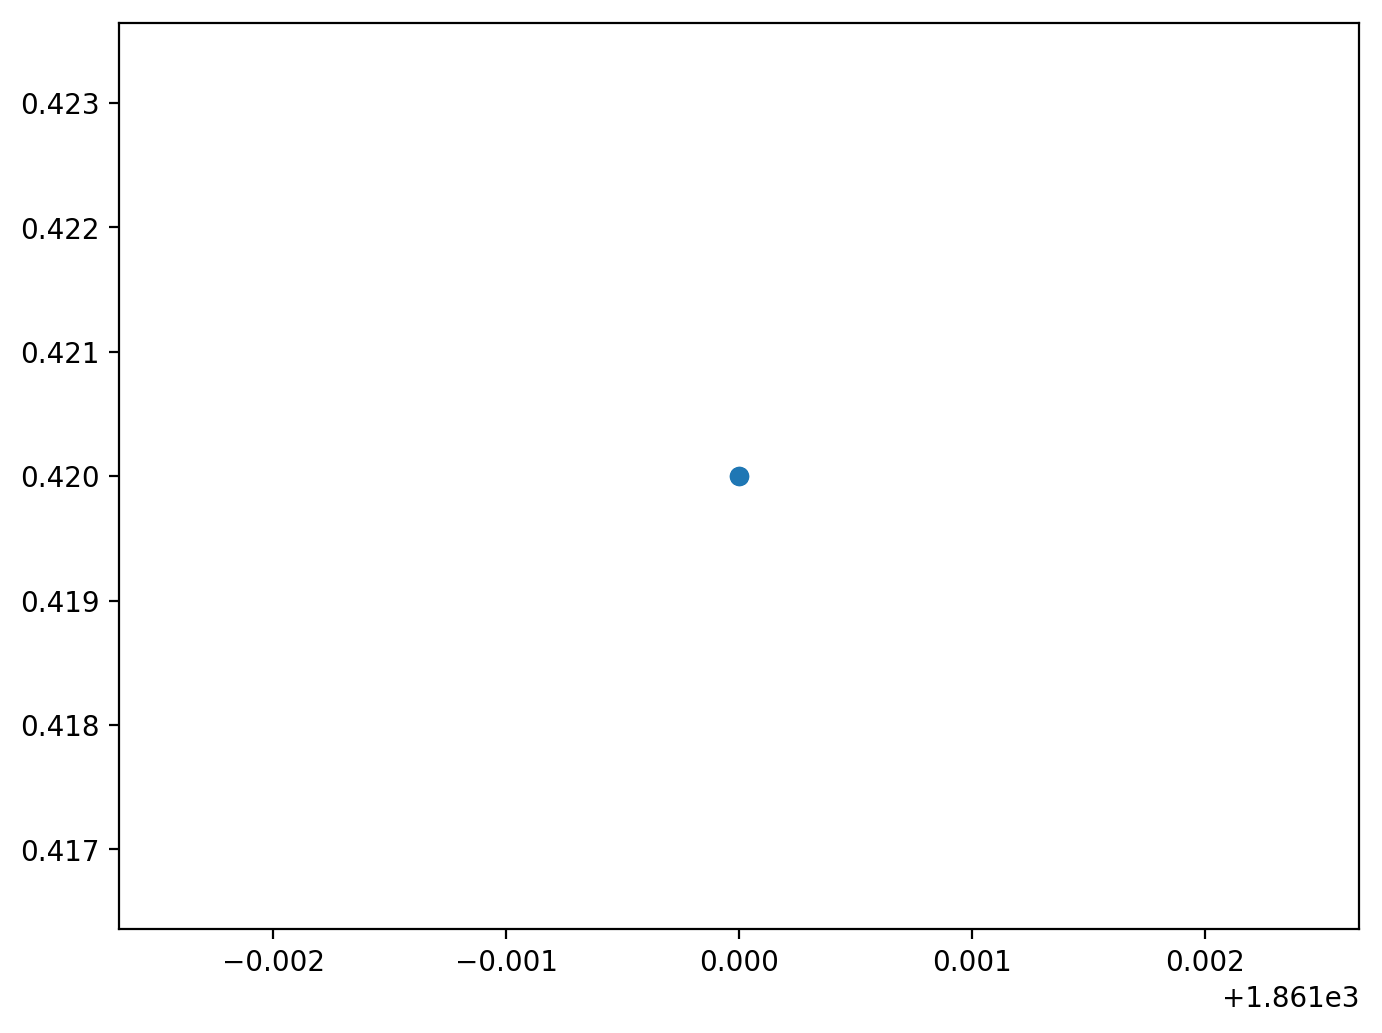

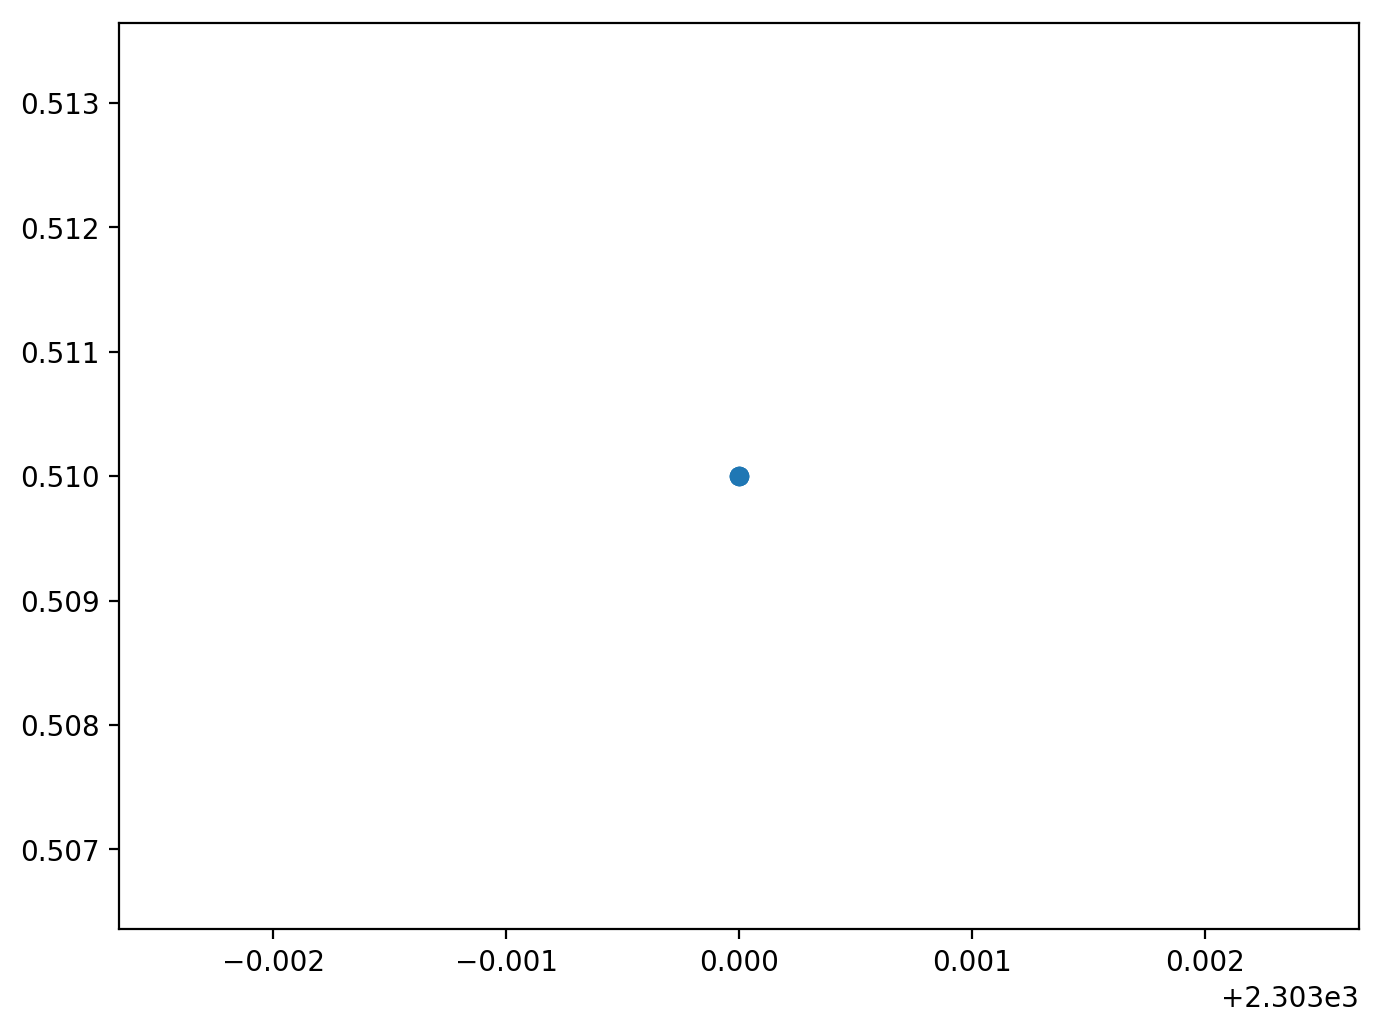

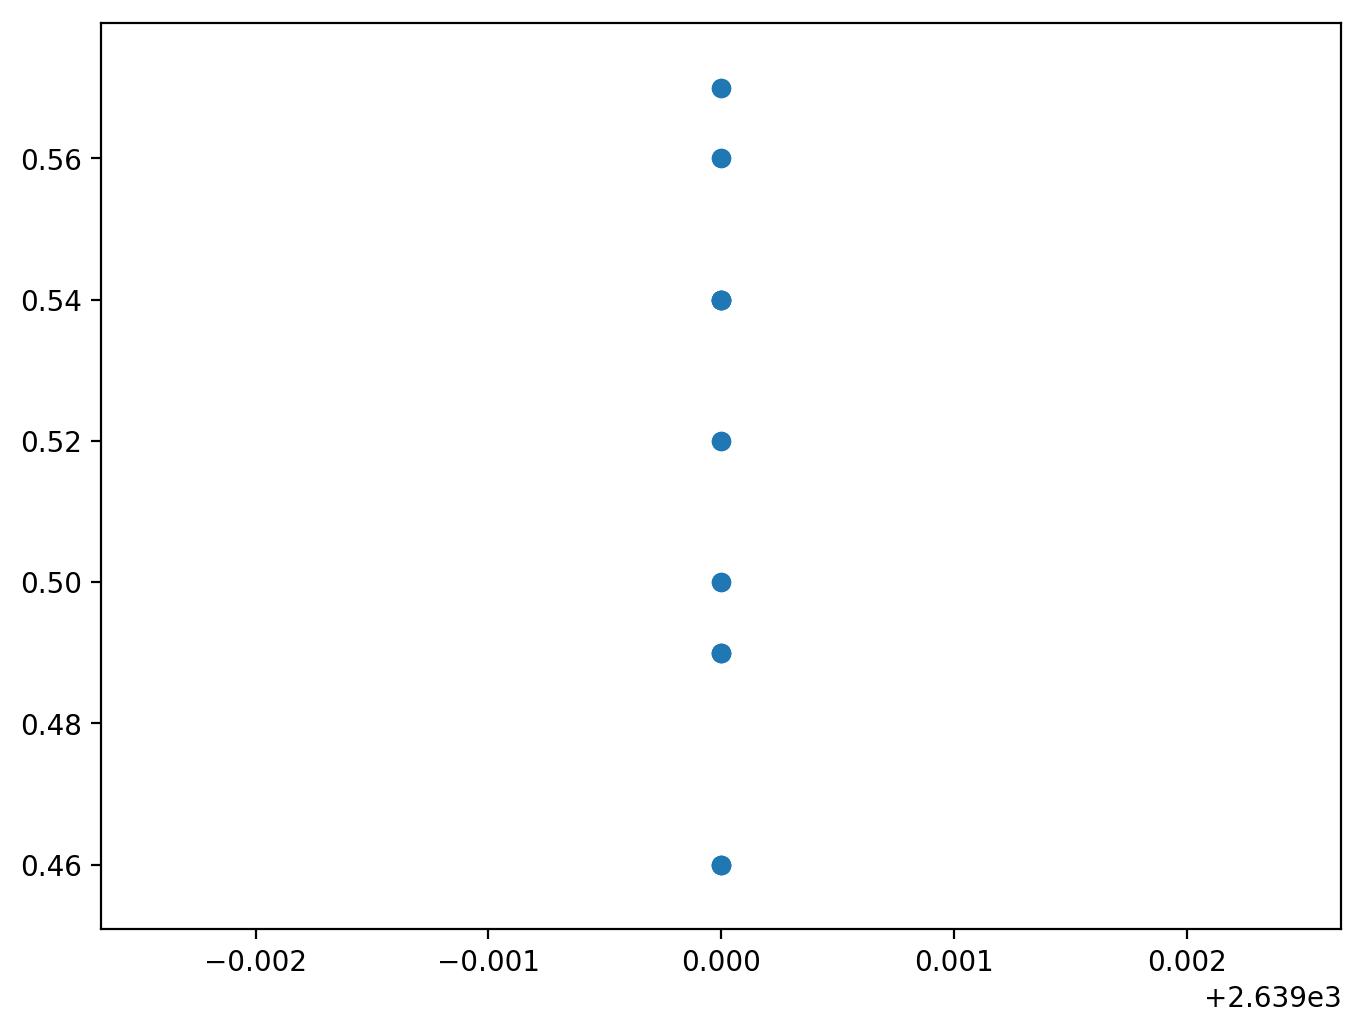

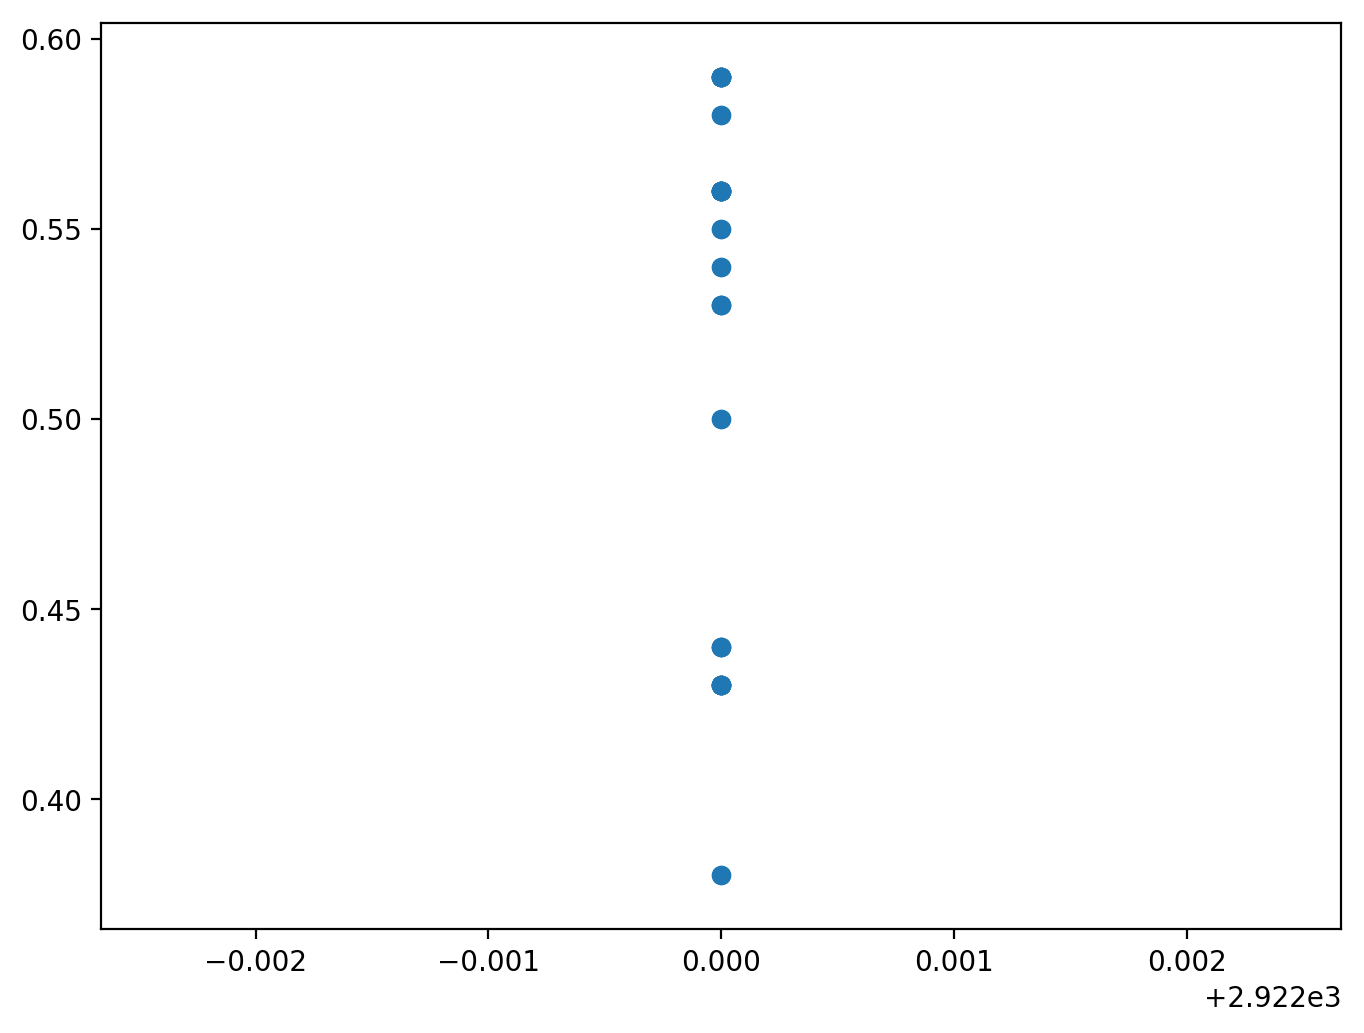

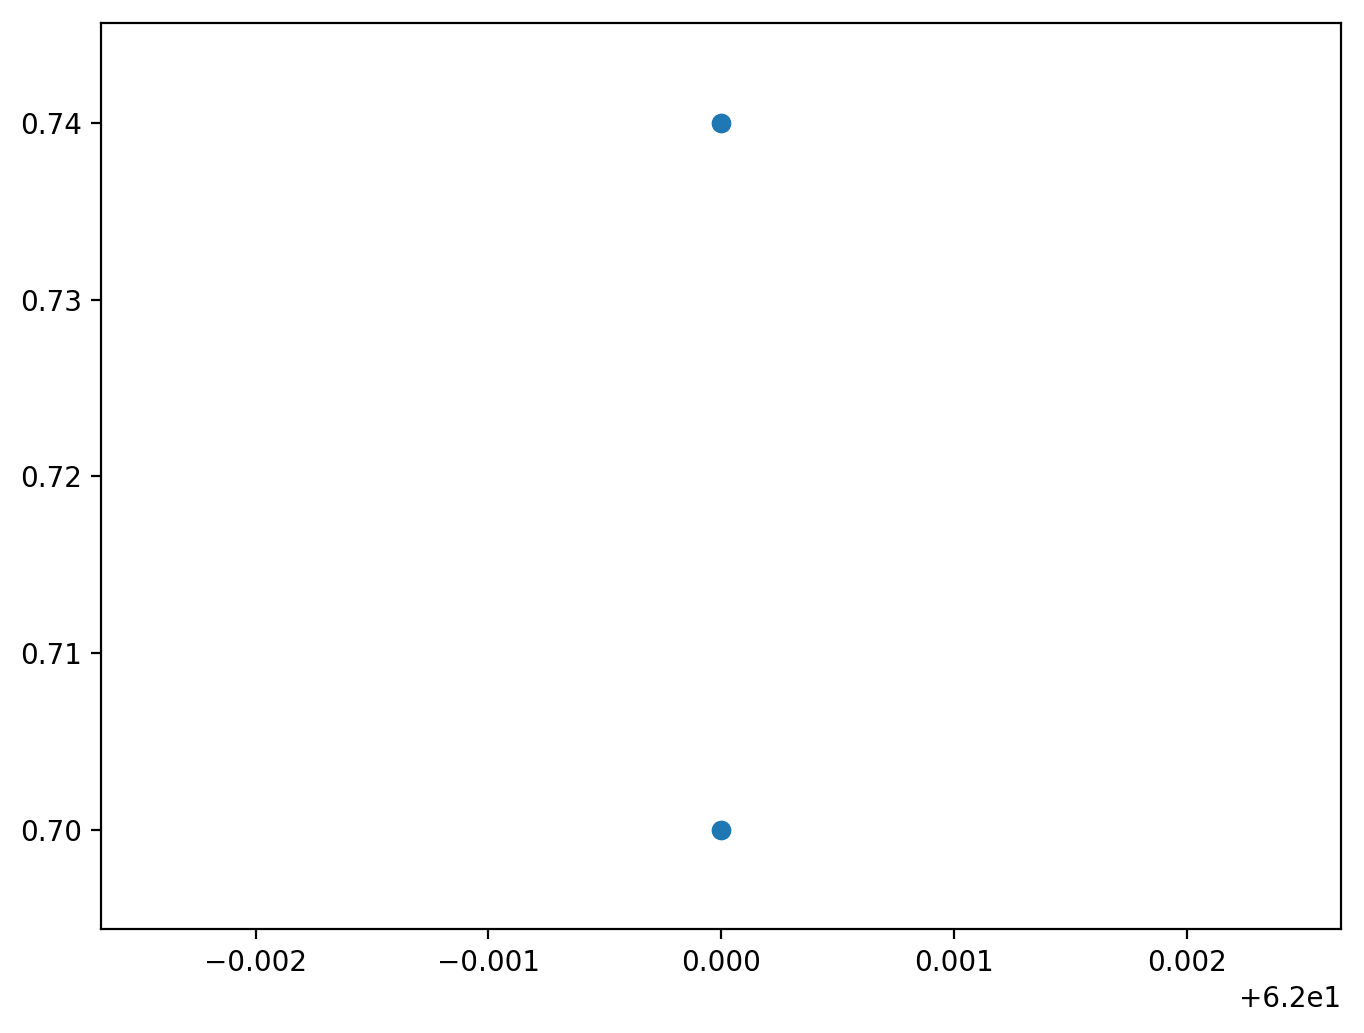

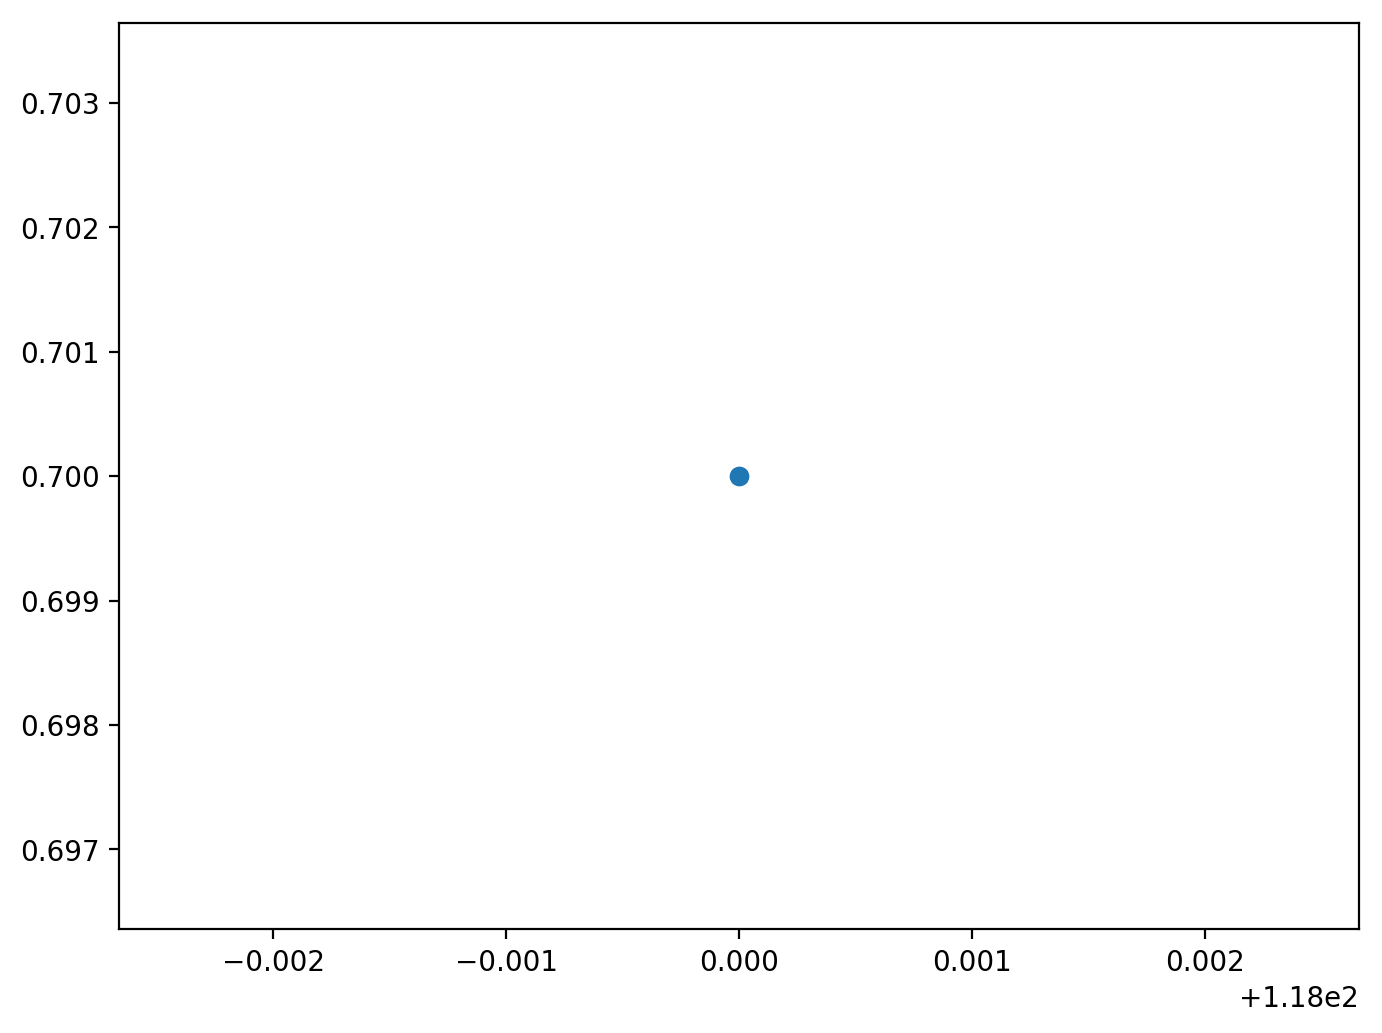

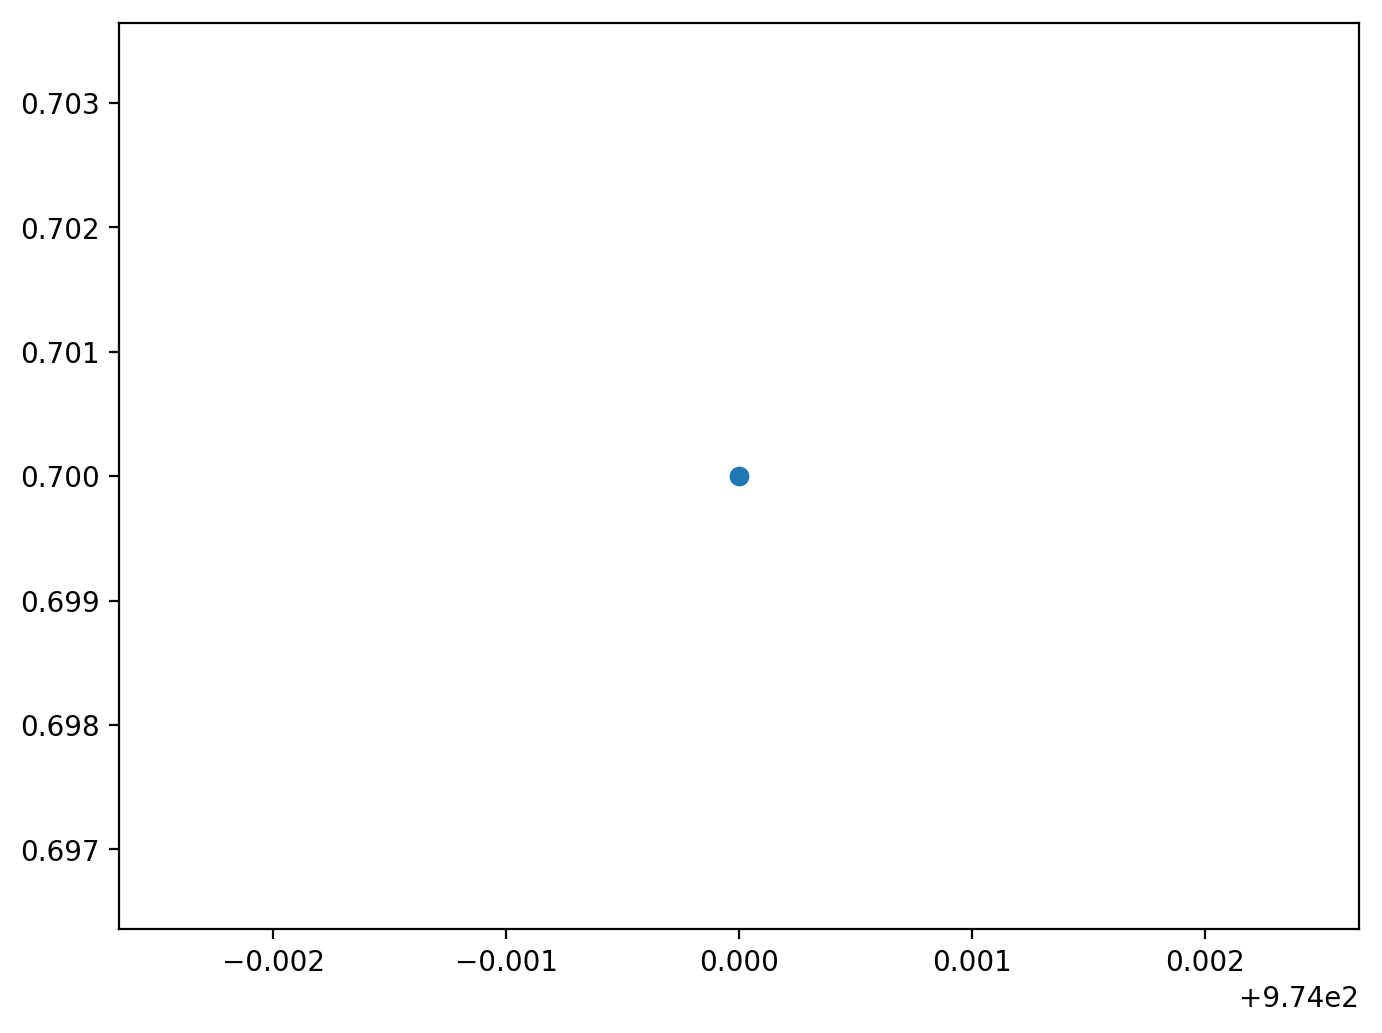

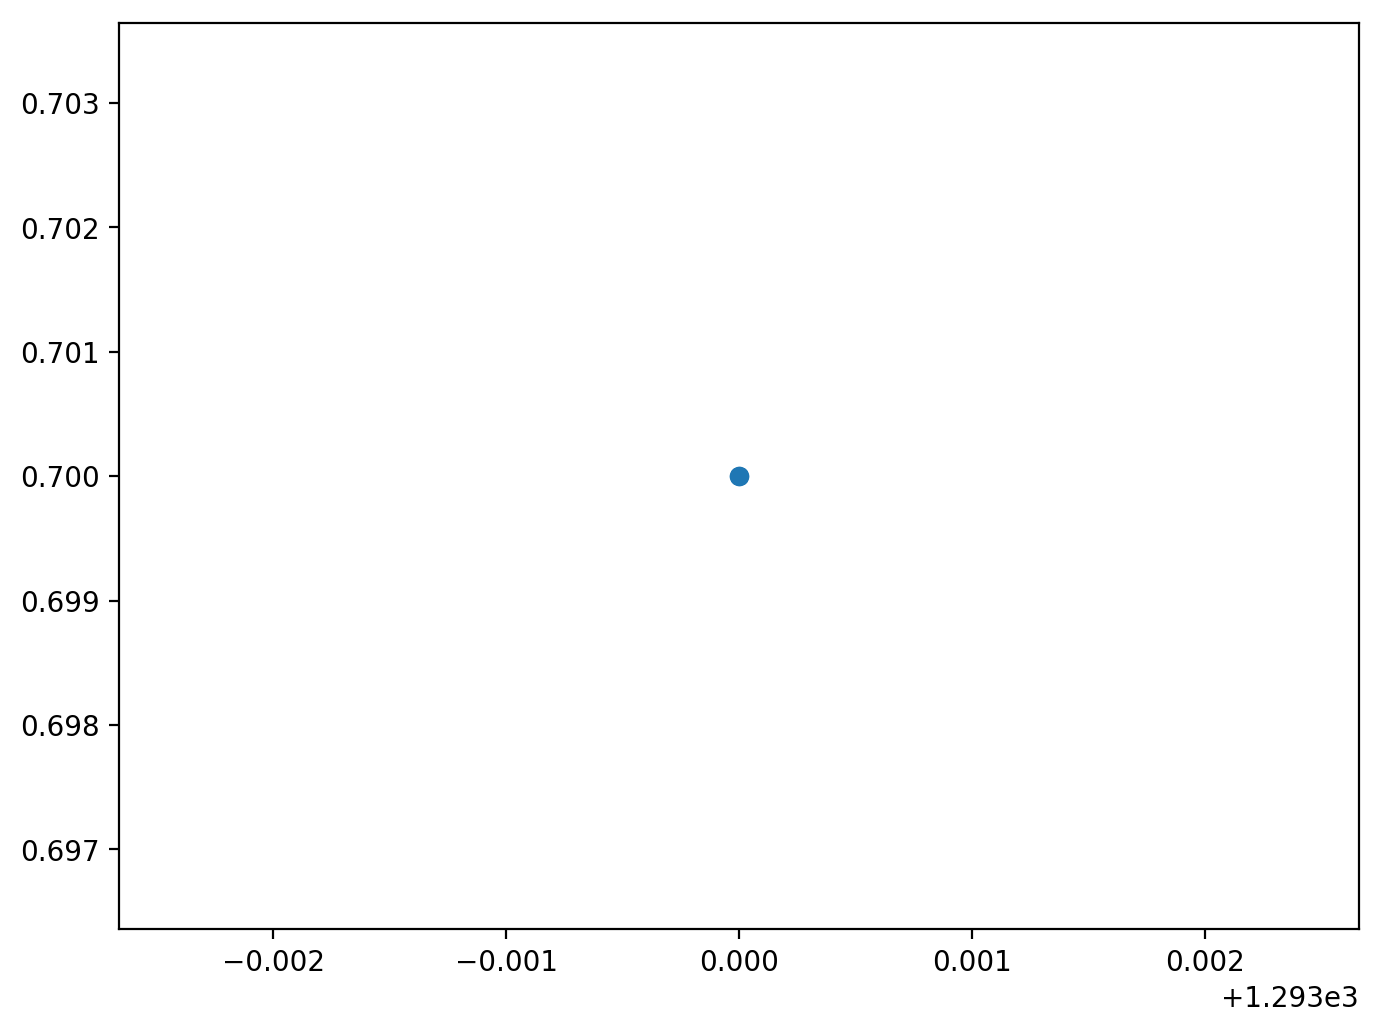

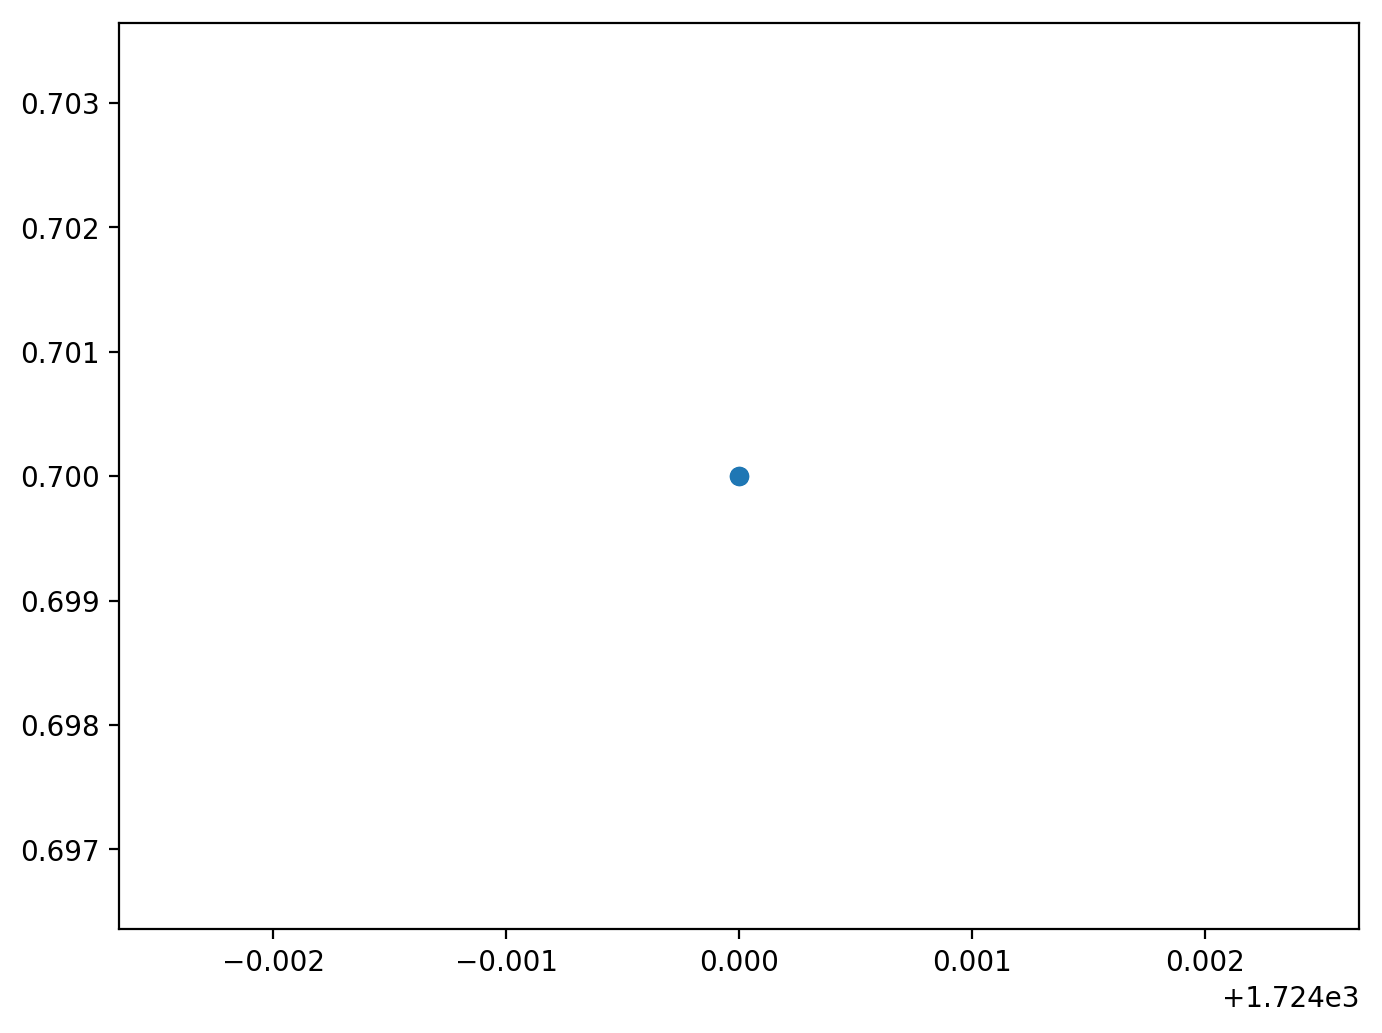

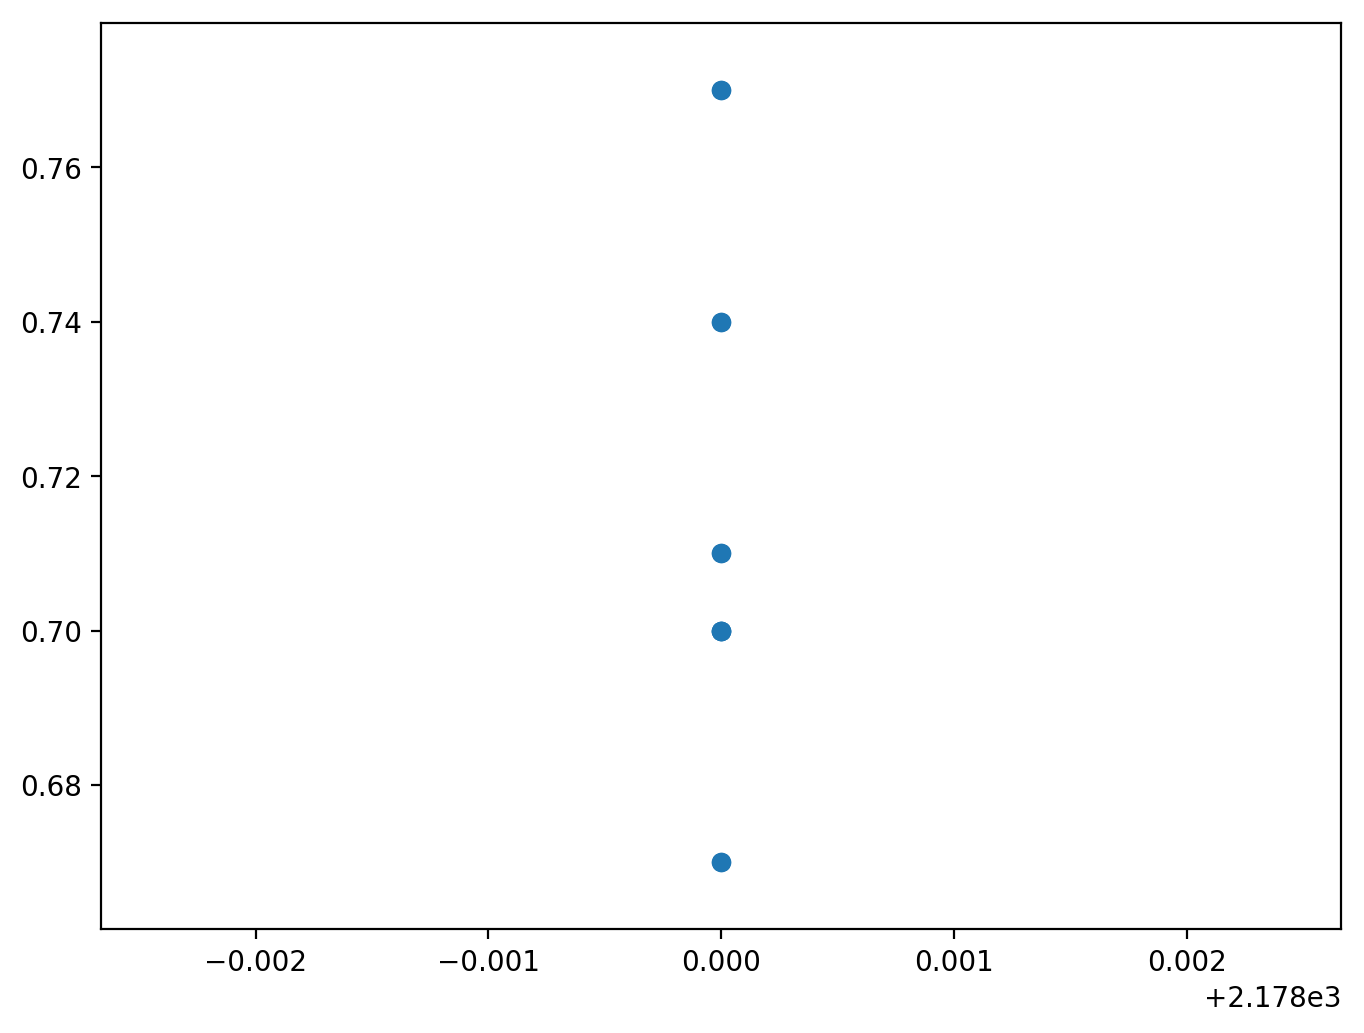

In [ ]:
for p in ['p1', 'p6', 'p8', 'p11']:
    for r in ['psi', 'V3']:
        df_tmp = test[(test['patient'] == p) & (test['region'] == r)]
        unique_days = df_tmp['day'].unique()
        for days in unique_days:
            fig, ax = plt.subplots(figsize=(8,6), dpi = 200)
            tmp = df_tmp[(test['day'] == days)]
            prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
            plt.scatter([days] * len(prob), prob)
        plt.savefig('../../../../results/prob_plots/' + 'prob_' + p + '_' + r + '_50_400dpi'+'.png')
        plt.close()

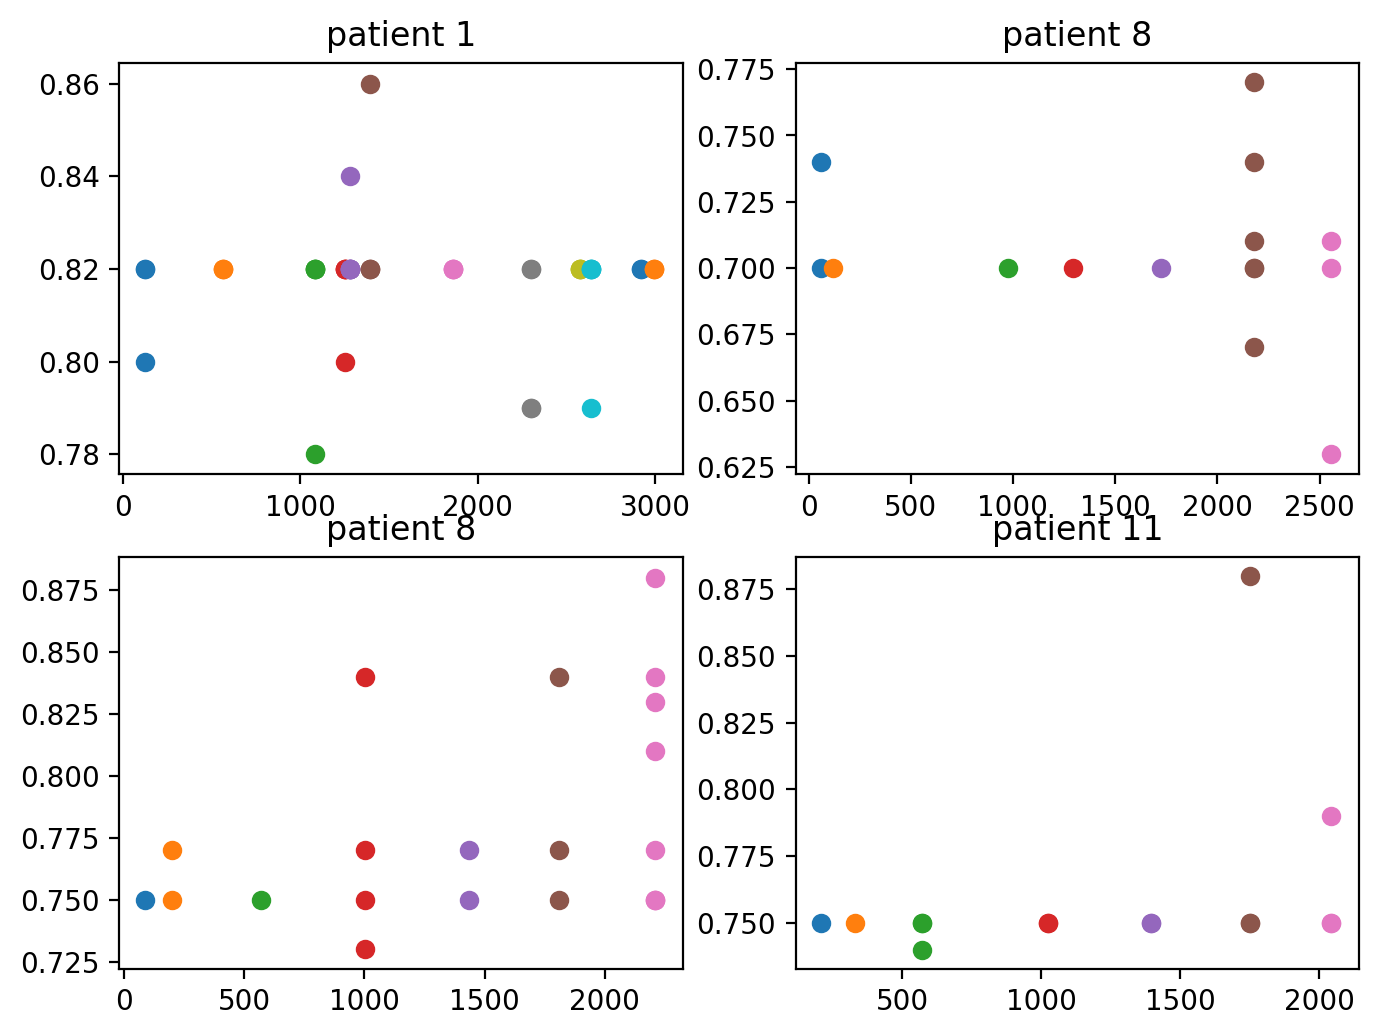

In [35]:
fig, ax = plt.subplots(2,2, figsize=(8,6), dpi = 200)
df_tmp = test[(test['patient'] == 'p1') & (test['region'] == 'psi')]
unique_days = df_tmp['day'].unique()
for days in unique_days:
    tmp = df_tmp[(test['day'] == days)]
    prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
    ax[0,0].scatter([days] * len(prob), prob)
    ax[0,0].set_title('patient 1')
df_tmp = test[(test['patient'] == 'p6') & (test['region'] == 'psi')]
unique_days = df_tmp['day'].unique()
for days in unique_days:
    tmp = df_tmp[(test['day'] == days)]
    prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
    ax[0,1].scatter([days] * len(prob), prob)
    ax[0,1].set_title('patient 8')
df_tmp = test[(test['patient'] == 'p8') & (test['region'] == 'psi')]
unique_days = df_tmp['day'].unique()
for days in unique_days:
    tmp = df_tmp[(test['day'] == days)]
    prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
    ax[1,0].scatter([days] * len(prob), prob)
    ax[1,0].set_title('patient 8')
df_tmp = test[(test['patient'] == 'p11') & (test['region'] == 'psi')]
unique_days = df_tmp['day'].unique()
for days in unique_days:
    tmp = df_tmp[(test['day'] == days)]
    prob = list(map(lambda x: x[0], clf_rf.predict_proba(tmp[tmp.columns[:20]])))
    ax[1,1].scatter([days] * len(prob), prob)
    ax[1,1].set_title('patient 11')
    